In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import dill
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import GaussianBlur
import lovely_tensors as lt
import wandb
from nnfabrik.builder import get_data

import csng
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters, plot_losses
from csng.losses import SSIMLoss, MSELossWithCrop, Loss, CroppedLoss
from csng.data import MixedBatchLoader
from csng.readins import (
    MultiReadIn,
    HypernetReadIn,
    ConvReadIn,
    AttentionReadIn,
    FCReadIn,
    AutoEncoderReadIn,
    Conv1dReadIn,
    LocalizedFCReadIn,
)

from BoostedInvertedEncoder import BoostedInvertedEncoder, ContextUnet
from encoder import get_encoder
from data_utils import (
    get_mouse_v1_data,
    append_syn_dataloaders,
    append_data_aug_dataloaders,
    RespGaussianNoise,
)

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

%env "WANDB_NOTEBOOK_NAME" "cnn_decoder.ipynb"
wandb.login()

DATA_PATH='/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22'
env: "WANDB_NOTEBOOK_NAME"="cnn_decoder.ipynb"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnny1188. Use `wandb login --relogin` to force relogin


True

In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    # "crop_win": None,
    # "crop_win": (slice(7, 29), slice(15, 51)),
    "crop_win": (22, 36),
    "wandb": None,
    # "wandb": {
    #     "project": "CSNG",
    #     "group": "sensorium_2022",
    # },
}
print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Data

In [4]:
dataloaders = dict()
config["data"]["mouse_v1"] = None
config["data"]["syn_dataset_config"] = None
config["data"]["data_augmentation"] = None

### Mouse V1 dataset (Sensorium 2022)

In [5]:
### prep data config
filenames = [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
    # "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # mouse 1
    # "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # sensorium+ (mouse 2)
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 3)
    # "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 4)
    # "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 5)
    # "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 6)
    # "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 7)
]
for f_idx, f_name in enumerate(filenames):
    filenames[f_idx] = os.path.join(DATA_PATH, f_name)

config["data"]["mouse_v1"] = {
    "paths": filenames,
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": filenames,
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        "batch_size": 12,
        # "batch_size": 7,
        "seed": config["seed"],
        "use_cache": False,
    },
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": config["device"],
}

In [6]:
### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config["data"])

Training dataset:	 4476 samples
Validation dataset:	 528 samples
Test dataset:		 180 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([7, 1, 36, 64])
  min=-1.750  max=2.225
  mean=0.093  std=0.944
responses:
  torch.Size([7, 8372])
  min=0.000  max=12.693
  mean=0.290  std=0.544
neuronal coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593


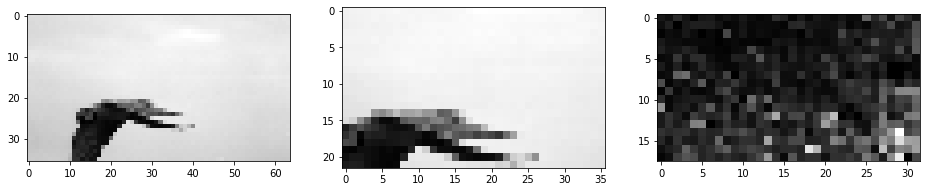

In [7]:
### show data
sample_data_key = dataloaders["mouse_v1"]["test"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["test"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[sample_data_key]
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_y_bins):
    for j in range(n_x_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[j] <= coords[:,0]) &\
               (coords[:,0] < x_bins[j + 1]) &\
               (y_bins[i] <= coords[:,1]) &\
               (coords[:,1] < y_bins[i + 1])
        binned_resp[i,j] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

### Synthetic dataset (different image stimuli -> encoder -> responses)

In [ ]:
### append synthetic data
config["data"]["syn_dataset_config"] = {
    "data_keys": [
        # "21067-10-18",
        # "22846-10-16",
        # "23343-5-17",
        # "23656-14-22",
        # "23964-4-22",
    ],
    "batch_size": 3,
    "append_data_parts": ["train"],
    # "data_key_prefix": "syn",
    "data_key_prefix": None,
}

dataloaders = append_syn_dataloaders(dataloaders, config=config["data"]["syn_dataset_config"])

In [ ]:
### show data
syn_stim, syn_resp, syn_pupil_center = next(iter(dataloaders["mouse_v1"]["train"].dataloaders[-1]))
syn_sample_data_key = dataloaders["mouse_v1"]["train"].data_keys[-1]
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {syn_stim.shape}"
    f"\n  min={syn_stim.min().item():.3f}  max={syn_stim.max().item():.3f}"
    f"\n  mean={syn_stim.mean().item():.3f}  std={syn_stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {syn_resp.shape}"
    f"\n  min={syn_resp.min().item():.3f}  max={syn_resp.max().item():.3f}"
    f"\n  mean={syn_resp.mean().item():.3f}  std={syn_resp.std().item():.3f}"
    "\nNeuron coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
    "\nPupil center:"
    f"\n  {syn_pupil_center.shape}"
    f"\n  min={syn_pupil_center.min().item():.3f}  max={syn_pupil_center.max().item():.3f}"
    f"\n  mean={syn_pupil_center.mean().item():.3f}  std={syn_pupil_center.std().item():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(syn_stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(syn_stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[syn_sample_data_key]
H, W = syn_stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_x_bins):
    for j in range(n_y_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[i] <= coords[:,0]) &\
               (coords[:,0] < x_bins[i + 1]) &\
               (y_bins[j] <= coords[:,1]) &\
               (coords[:,1] < y_bins[j + 1])
        binned_resp[j,i] = syn_resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

## Encoder

In [8]:
encoder = get_encoder(device=config["device"], eval_mode=True)

Loading encoder checkpoint from /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/encoder_sens22.pth


In [ ]:
### load encoder
print("Loading encoder...")

from lurz2020.models.models import se2d_fullgaussian2d

### load pretrained encoder ckpt
encoder_ckpt = torch.load(
    os.path.join(DATA_PATH, "models", "encoder.pt"),
    map_location=config["device"],
    pickle_module=dill,
)

### get temporary dataloaders for the encoder
_dataloaders = get_data(
    encoder_ckpt["config"]["data"]["dataset_fn"],
    encoder_ckpt["config"]["data"]["dataset_config"]
)

### init encoder
encoder = se2d_fullgaussian2d(
    **encoder_ckpt["config"]["encoder"]["model_config"],
    dataloaders=_dataloaders,
    seed=encoder_ckpt["config"]["seed"],
).float()
encoder.load_state_dict(encoder_ckpt["encoder_state"], strict=True)
encoder.to(config["device"])
encoder.eval()
del _dataloaders

## Decoder

In [9]:
def train(model, dataloader, verbose=True):
    model.train()
    train_loss = 0
    n_batches = len(dataloader)

    ### run
    for batch_idx, b in enumerate(dataloader):
        loss = 0

        ### combine from all data keys
        for data_key, stim, resp, neuron_coords, pupil_center in b:
            ### get loss
            # stim_pred, _, _ = model(
            #     resp=resp,
            #     data_key=data_key,
            #     train=True,
            #     stim_target=stim,
            #     neuron_coords=neuron_coords,
            #     pupil_center=pupil_center,
            # )
            loss += model.fit_direct_iter(
                resp=resp,
                stim_target=stim,
                data_key=data_key,
                neuron_coords=neuron_coords,
                pupil_center=pupil_center,
            )
            # loss += loss_fn(stim_pred, stim, data_key=data_key, phase="train", neuron_coords=neuron_coords, pupil_center=pupil_center)
            # model.refiner.set_additional_loss(
            #     inp={
            #         "resp": resp,
            #         "stim": stim,
            #         "neuron_coords": neuron_coords,
            #         "pupil_center": pupil_center,
            #         "data_key": data_key,
            #     }, out={
            #         "stim_pred": stim_pred,
            #     },
            # )
            # loss += model.refiner.get_additional_loss(data_key=data_key)

        ### update
        loss /= len(b)

        ### log
        train_loss += loss
        if verbose and batch_idx % 100 == 0:
            print(f"Training progress: [{batch_idx}/{n_batches} ({100. * batch_idx / n_batches:.0f}%)]"
                  f"  Loss: {loss:.6f}")

    train_loss /= n_batches
    return train_loss

In [10]:
def val(model, dataloader, loss_fn, config, only_data_keys=None):
    model.eval()
    val_losses = {"total": 0}
    n_samples = 0
    denom_data_keys = {}

    for b in dataloader:
        ### combine from all data keys
        for data_key, stim, resp, neuron_coords, pupil_center in b:
            if only_data_keys is not None and data_key not in only_data_keys:
                continue
            stim_pred, _, _ = model(
                resp=resp,
                data_key=data_key,
                train=False,
                stim_target=None,
                neuron_coords=neuron_coords,
                pupil_center=pupil_center,
            )
            loss = loss_fn(stim_pred, stim, data_key=data_key, phase="val").item()
            val_losses["total"] += loss
            val_losses[data_key] = loss if data_key not in val_losses else val_losses[data_key] + loss
            denom_data_keys[data_key] = denom_data_keys[data_key] + resp.shape[0] if data_key in denom_data_keys else resp.shape[0]
            n_samples += resp.shape[0]

    val_losses["total"] /= n_samples
    for k in denom_data_keys:
        val_losses[k] /= denom_data_keys[k]
    return val_losses

In [11]:
def get_all_data(config):
    dls, neuron_coords = get_mouse_v1_data(config=config["data"])
    if "syn_dataset_config" in config["data"] and config["data"]["syn_dataset_config"] is not None:
        dls = append_syn_dataloaders(dls, config=config["data"]["syn_dataset_config"]) # append synthetic data
    if "data_augmentation" in config["data"] and config["data"]["data_augmentation"] is not None:
        dls = append_data_aug_dataloaders(
            dataloaders=dls,
            config=config["data"]["data_augmentation"],
        )
    return dls, neuron_coords

In [12]:
l1 = nn.MSELoss()
l2 = SSIMLoss(log_loss=True, inp_normalized=True, inp_standardized=False)
loss_fn_combined = lambda pred, target: 0.7 * l1(pred, target) + 0.3 * l2(pred, target)

[WARNING] Setting nonnegative_ssim to True as log_loss is set to True.


In [13]:
config["decoder"] = {
    "model": {
        "encoder": encoder,
        "img_dims": (1, 36, 64),
        "stim_pred_init": "zeros",
        "opter_cls": torch.optim.SGD,
        "opter_config": {"lr": 1500, "momentum": 0},
        "n_steps": 10,
        "last_enc_inv_step": 1,
        "resp_loss_fn": nn.MSELoss(reduction="sum"),
        "stim_loss_fn": SSIMLoss(
            window=config["crop_win"],
            log_loss=True,
            inp_normalized=True,
            inp_standardized=False,
        ),
        "img_gauss_blur_config": None,
        "img_grad_gauss_blur_config": {"kernel_size": 17, "sigma": 2},
        "img_normalize": True,
        "refiner_cls": MultiReadIn,
        "refiner_config": {
            "readins_config": [
                {
                    "data_key": data_key,
                    "in_shape": n_coords.shape[-2],
                    "decoding_objective_config": None,
                    "layers": [
                        (ConvReadIn, {
                            # "H": 9,
                            # "W": 16,
                            # "H": 11,
                            # "W": 18,
                            "H": 5,
                            "W": 9,
                            "shift_coords": True,
                            "learn_grid": True,
                            "grid_net_config": {
                                "in_channels": 4, # x, y, z, resp
                                # "layers_config": [("fc", 32), ("fc", 64), ("fc", 9*16)],
                                # "layers_config": [("fc", 32), ("fc", 64), ("fc", 11*18)],
                                "layers_config": [("fc", 16), ("fc", 64), ("fc", 5*9)],
                                "act_fn": nn.LeakyReLU,
                                "out_act_fn": nn.Identity,
                                "dropout": 0.1,
                                "batch_norm": False,
                            },
                            "grid_l1_reg": 8e-3,
                            "in_channels_group_size": 1,
                            "pointwise_conv_config": None,
                            # "pointwise_conv_config": {
                            #     "in_channels": n_coords.shape[-2],
                            #     "out_channels": 256,
                            #     "act_fn": nn.LeakyReLU,
                            #     # "act_fn": nn.Identity,
                            #     "bias": False,
                            #     "batch_norm": True,
                            # },
                            "gauss_blur": False,
                            "gauss_blur_kernel_size": 9,
                            # "gauss_blur_sigma": "fixed", # "fixed", "single", "per_neuron"
                            "gauss_blur_sigma": "per_neuron", # "fixed", "single", "per_neuron"
                            "gauss_blur_sigma_init": 1,
                            "neuron_emb_dim": None,
                            "out_channels": resp.shape[-1],
                            # "out_channels": 145,
                        }),
                        # (nn.Upsample, {"scale_factor": 2}, 145),
                        # (nn.Linear, {"in_features": n_coords.shape[-2], "out_features": 512}, 512),
                    ],
                } for data_key, n_coords in dataloaders["mouse_v1"]["train"].neuron_coords.items()
            ],
            # "core_cls": CNN_Decoder,
            "core_cls": ContextUnet,
            "core_config": {
                ### CNN_Decoder
                # "resp_shape": [145],
                # "stim_shape": list(stim.shape[1:]),
                # "layers": [
                #     ### for conv_readin
                #     ("conv", 128, 7, 1, 3),
                #     ("conv", 64, 5, 1, 2),
                #     ("conv", 64, 3, 1, 1),
                #     # ("conv", 32, 3, 1, 1),
                #     ("conv", 1, 3, 1, 1),
                # ],
                # "act_fn": nn.ReLU,
                # "out_act_fn": nn.Identity,
                # "dropout": 0.3,
                # "batch_norm": True,
                
                ### ContextUnet
                # "in_channels": 145,
                "resp_channels": resp.shape[-1],
                # "resp_channels": 256,
                "out_channels": 1,
                "channels": (64,128,256),
                "bottleneck_avgpool": False,
                "gn_mul_context": {
                    "in_shape": (1,),
                    "embed_type": "fc",
                },
                "gn_add_context": None,
                "c3_config": {
                    "in_shape": (1,22,36),
                    "use_as": "input",
                }
            },
        },
        "refiner_opter_cls": torch.optim.Adam,
        "refiner_opter_config": {"lr": 3e-4},
        "refiner_crop_win": (22, 36),
        "refiner_freq": 1,
        "refiner_loss_fn": {
            # "loss_fn": MSELossWithCrop(window=config["crop_win"], standardize=False),
            # "loss_fn": SSIMLoss(
            #     window=config["crop_win"],
            #     log_loss=True,
            #     inp_normalized=True,
            #     inp_standardized=False,
            # ),
            "loss_fn": CroppedLoss(
                window=config["crop_win"],
                # loss_fn=nn.MSELoss(),
                loss_fn=loss_fn_combined,
            ),
            "l1_reg_mul": 0,
            "l2_reg_mul": 3e-5,
            "con_reg_mul": 0,
            # "con_reg_mul": 1,
            "con_reg_loss_fn": SSIMLoss(
                window=config["crop_win"],
                log_loss=True,
                inp_normalized=True,
                inp_standardized=False,
            ),
            "encoder": None,
            # "encoder": encoder,
        },
        "eps_noise_after_refiner": 0.003,
        "device": config["device"],
    },
    "n_epochs": 600,
    "load_ckpt": None,
    # "load_ckpt": {
    #     # "load_only_core": False,
    #     "load_only_core": True,
    #     "ckpt_path": os.path.join(
    #         DATA_PATH, "models", "cat_v1_pretraining", "2024-02-27_19-17-39", "decoder.pt"),
    #         # DATA_PATH, "models", "cnn", "2023-08-25_09-07-46", "ckpt", "decoder_40.pt"),
    # },
    "save_run": False,
}

[WARNING] Setting nonnegative_ssim to True as log_loss is set to True.
[WARNING] Setting nonnegative_ssim to True as log_loss is set to True.


In [14]:
### initialize (and load ckpt if needed)
if config["decoder"]["load_ckpt"] != None:
    raise NotImplementedError("Loading ckpt not implemented yet.")
    print(f"[INFO] Loading checkpoint from {config['decoder']['load_ckpt']['ckpt_path']}...")
    ckpt = torch.load(config["decoder"]["load_ckpt"]["ckpt_path"], map_location=config["device"], pickle_module=dill)

    if config["decoder"]["load_ckpt"]["load_only_core"]:
        print("[INFO] Loading only the core of the model (no history, no best ckpt)...")

        ### init decoder (load only the core)
        config["decoder"]["model"]["core_cls"] = ckpt["config"]["decoder"]["model"]["core_cls"]
        config["decoder"]["model"]["core_config"] = ckpt["config"]["decoder"]["model"]["core_config"]
        decoder = MultiReadIn(**config["decoder"]["model"]).to(config["device"])
        decoder.load_state_dict({k:v for k,v in ckpt["best"]["model"].items() if "readin" not in k}, strict=False)

        ### init the rest
        opter = config["decoder"]["opter_cls"](decoder.parameters(), **config["decoder"]["opter_kwargs"])
        loss_fn = Loss(model=decoder, config=config["decoder"]["loss"])
        history = {"train_loss": [], "val_loss": []}
        best = {"val_loss": np.inf, "epoch": 0, "model": None}
    else:
        print("[INFO] Loading the whole model (the latest - not the BEST; with history and best ckpt)...")
        history, config["decoder"]["model"], best = ckpt["history"], ckpt["config"]["decoder"]["model"], ckpt["best"]

        decoder = MultiReadIn(**config["decoder"]["model"]).to(config["device"])
        decoder.load_state_dict(ckpt["decoder"])

        opter = config["decoder"]["opter_cls"](decoder.parameters(), **config["decoder"]["opter_kwargs"])
        opter.load_state_dict(ckpt["opter"])
        loss_fn = Loss(model=decoder, config=config["decoder"]["loss"])
else:
    print("[INFO] Initializing the model from scratch...")
    decoder = BoostedInvertedEncoder(**config["decoder"]["model"]).to(config["device"])
    decoder.refiner_loss_fn = Loss(model=decoder.refiner, config=config["decoder"]["model"]["refiner_loss_fn"])
    # loss_fn_train = decoder.refiner_loss_fn
    loss_fn_val = Loss(model=None, config={"loss_fn": decoder.stim_loss_fn})

    history = {"train_loss": [], "val_loss": []}
    best = {"val_loss": np.inf, "epoch": 0, "model": None}

[INFO] Initializing the model from scratch...


In [ ]:
### print model and fix sizes of stimuli
stim_pred, _, _ = decoder(resp.to(config["device"]), train=False, data_key=sample_data_key, neuron_coords=neuron_coords[sample_data_key], pupil_center=pupil_center.to(config["device"]))
if stim_pred.shape != crop(stim, config["crop_win"]).shape:
    print(f"[WARNING] Stimulus prediction shape {stim_pred.shape} does not match stimulus shape {crop(stim, config['crop_win']).shape}.")
    assert stim_pred.shape[-2] >= crop(stim, config["crop_win"]).shape[-2] \
        and stim_pred.shape[-1] >= crop(stim, config["crop_win"]).shape[-1]
    
    # ### set crop function
    # decoder.crop_stim_fn = lambda x: x[:, :, :crop(stim, config["crop_win"]).shape[-2], :crop(stim, config["crop_win"]).shape[-1]]
    # stim_pred = decoder(resp.to(config["device"]), data_key=sample_data_key, neuron_coords=neuron_coords[sample_data_key], pupil_center=pupil_center.to(config["device"]))
    # print(f"[INFO] Stimulus prediction shape cropped to {stim_pred.shape}.")

print(stim_pred.shape)
del stim_pred

print(
    f"Number of parameters:"
    f"\n  whole refiner model: {count_parameters(decoder.refiner)}"
    f"\n  refiner core: {count_parameters(decoder.refiner.core)} ({count_parameters(decoder.refiner.core) / count_parameters(decoder.refiner) * 100:.2f}%)"
    f"\n  refiner readins: {count_parameters(decoder.refiner.readins)} ({count_parameters(decoder.refiner.readins) / count_parameters(decoder.refiner) * 100:.2f}%)"
    f"\n    ({', '.join([f'{k}: {count_parameters(v)} [{count_parameters(v) / count_parameters(decoder.refiner) * 100:.2f}%]' for k, v in decoder.refiner.readins.items()])})"
)

decoder

In [15]:
### prepare checkpointing and wandb logging
config["run_name"] = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
if config["decoder"]["save_run"]:
    ### save config
    config["dir"] = os.path.join(DATA_PATH, "models", "boosted_inverted_encoder", config["run_name"])
    os.makedirs(config["dir"], exist_ok=True)
    with open(os.path.join(config["dir"], "config.json"), "w") as f:
        json.dump(config, f, indent=4, default=str)
    os.makedirs(os.path.join(config["dir"], "samples"), exist_ok=True)
    os.makedirs(os.path.join(config["dir"], "ckpt"), exist_ok=True)
    make_sample_path = lambda epoch, prefix: os.path.join(
        config["dir"], "samples", f"{prefix}stim_comparison_{epoch}e.png"
    )

    print(f"Run name: {config['run_name']}\nRun dir: {config['dir']}")
else:
    make_sample_path = lambda epoch, prefix: None
    print("[WARNING] Not saving the run and the config.")

if config["wandb"]:
    wdb_run = wandb.init(**config["wandb"], name=config["run_name"], config=config,
        tags=[
            config["decoder"]["model"]["core_cls"].__name__,
            config["decoder"]["model"]["readins_config"][0]["layers"][0][0].__name__,
            # "contrastive_regularization",
            # "cat_v1_pretraining"
        ],
        notes=None)
    wdb_run.watch(decoder)
else:
    print("[WARNING] Not using wandb.")

[WARNING] Not saving the run and the config.
[WARNING] Not using wandb.


[1/600]
Training progress: [0/373 (0%)]  Loss: 3.842180
Training progress: [100/373 (27%)]  Loss: 0.324931
Training progress: [200/373 (54%)]  Loss: 0.240210
Training progress: [300/373 (80%)]  Loss: 0.284458
train_loss=0.3760


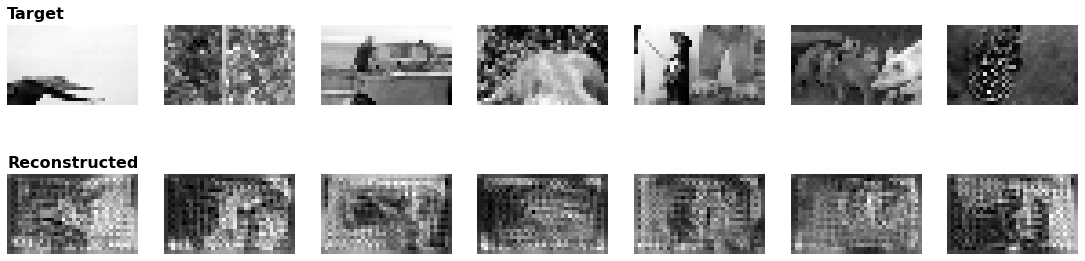

[2/600]
Training progress: [0/373 (0%)]  Loss: 0.243684
Training progress: [100/373 (27%)]  Loss: 0.222319
Training progress: [200/373 (54%)]  Loss: 0.195237
Training progress: [300/373 (80%)]  Loss: 0.198598
train_loss=0.2639


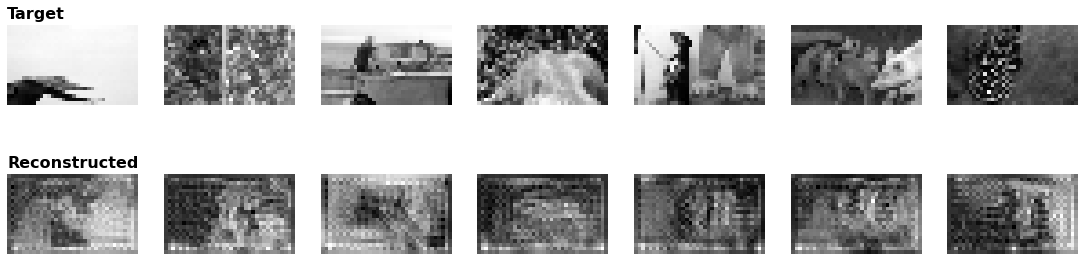

[3/600]
Training progress: [0/373 (0%)]  Loss: 0.208929
Training progress: [100/373 (27%)]  Loss: 0.191862
Training progress: [200/373 (54%)]  Loss: 0.162956
Training progress: [300/373 (80%)]  Loss: 0.177125
train_loss=0.2166


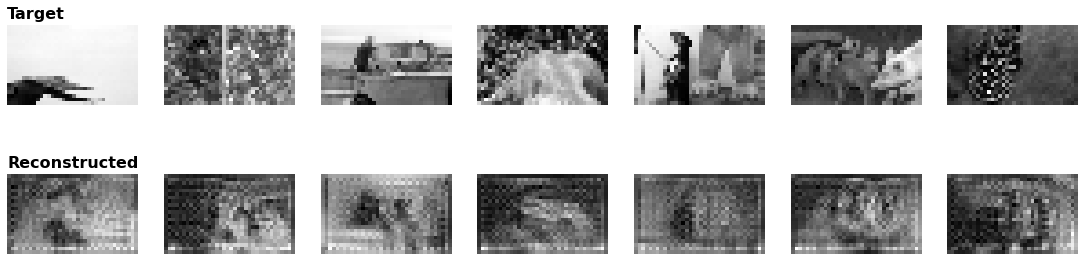

[4/600]
Training progress: [0/373 (0%)]  Loss: 0.180779
Training progress: [100/373 (27%)]  Loss: 0.154073
Training progress: [200/373 (54%)]  Loss: 0.117569
Training progress: [300/373 (80%)]  Loss: 0.157230
train_loss=0.1753


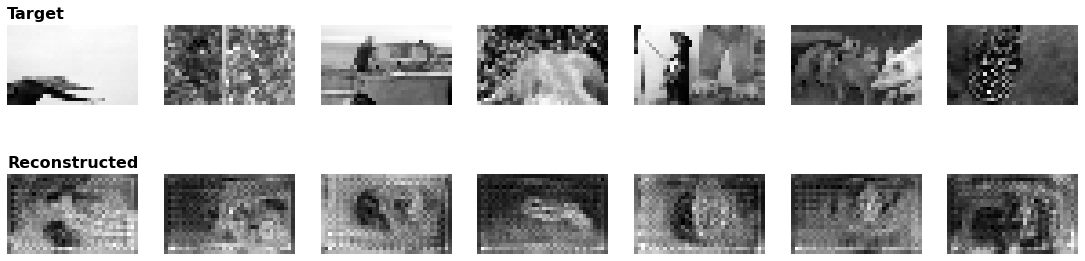

[5/600]
Training progress: [0/373 (0%)]  Loss: 0.151924
Training progress: [100/373 (27%)]  Loss: 0.128782
Training progress: [200/373 (54%)]  Loss: 0.101923
Training progress: [300/373 (80%)]  Loss: 0.136527
train_loss=0.1480


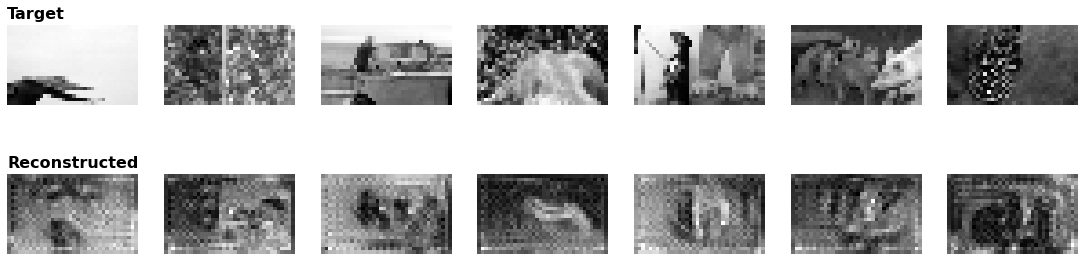

[6/600]
Training progress: [0/373 (0%)]  Loss: 0.120557
Training progress: [100/373 (27%)]  Loss: 0.106943
Training progress: [200/373 (54%)]  Loss: 0.081414
Training progress: [300/373 (80%)]  Loss: 0.100914
train_loss=0.1286


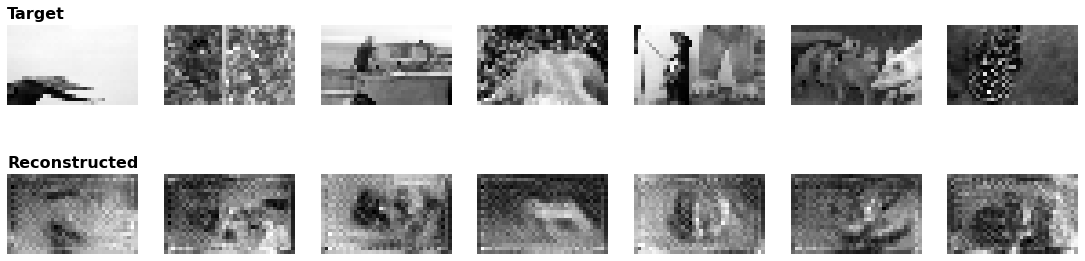

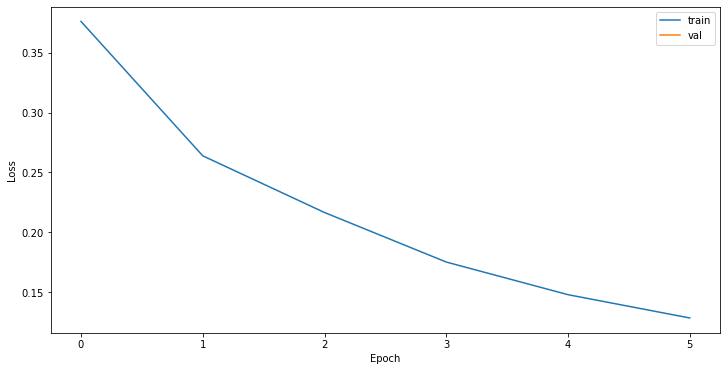

[7/600]
Training progress: [0/373 (0%)]  Loss: 0.102921
Training progress: [100/373 (27%)]  Loss: 0.093911
Training progress: [200/373 (54%)]  Loss: 0.071781
Training progress: [300/373 (80%)]  Loss: 0.087324
train_loss=0.1145


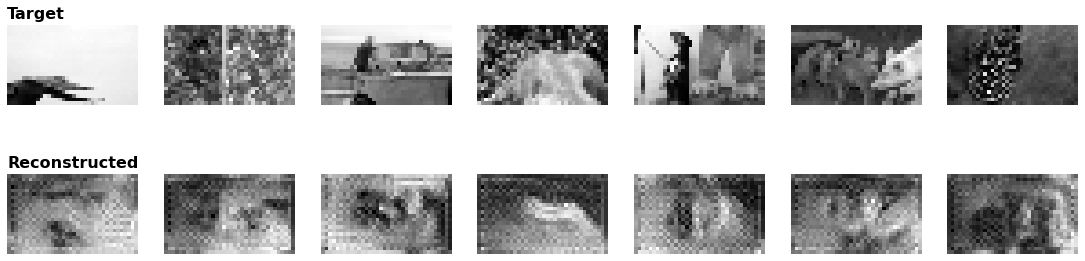

[8/600]
Training progress: [0/373 (0%)]  Loss: 0.100900
Training progress: [100/373 (27%)]  Loss: 0.083854
Training progress: [200/373 (54%)]  Loss: 0.067772
Training progress: [300/373 (80%)]  Loss: 0.083759
train_loss=0.1035


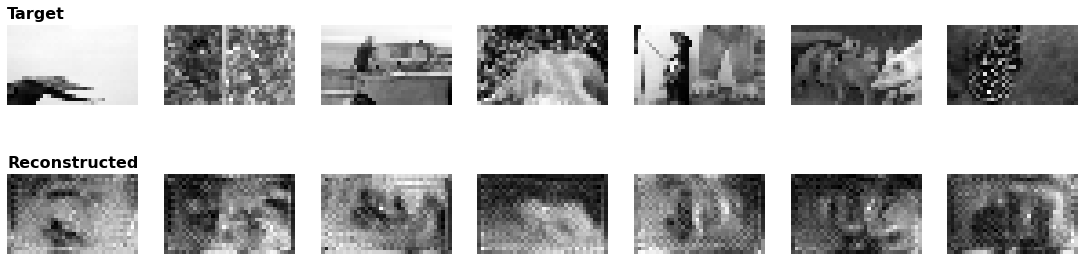

[9/600]
Training progress: [0/373 (0%)]  Loss: 0.088158
Training progress: [100/373 (27%)]  Loss: 0.070134
Training progress: [200/373 (54%)]  Loss: 0.061308
Training progress: [300/373 (80%)]  Loss: 0.076485
train_loss=0.0912


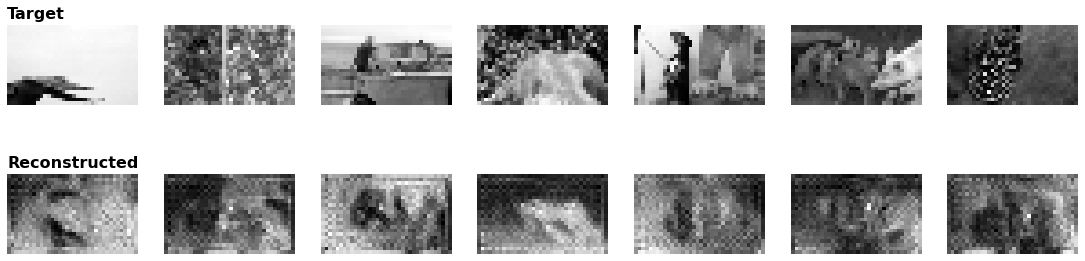

[10/600]
Training progress: [0/373 (0%)]  Loss: 0.068349
Training progress: [100/373 (27%)]  Loss: 0.059509
Training progress: [200/373 (54%)]  Loss: 0.052750
Training progress: [300/373 (80%)]  Loss: 0.066226
train_loss=0.0812


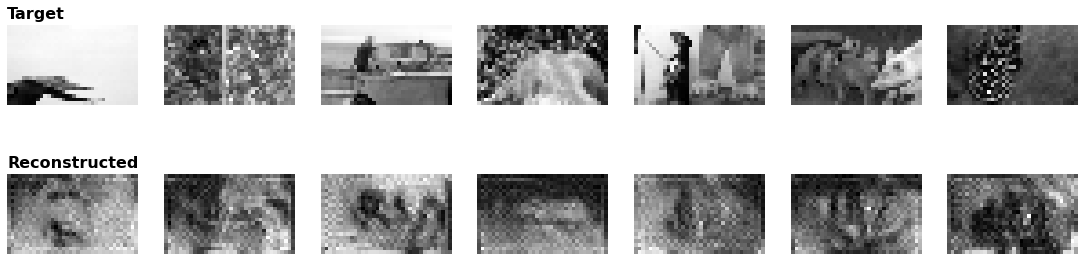

[11/600]
Training progress: [0/373 (0%)]  Loss: 0.059515
Training progress: [100/373 (27%)]  Loss: 0.055297
Training progress: [200/373 (54%)]  Loss: 0.051021
Training progress: [300/373 (80%)]  Loss: 0.074441
train_loss=0.0718


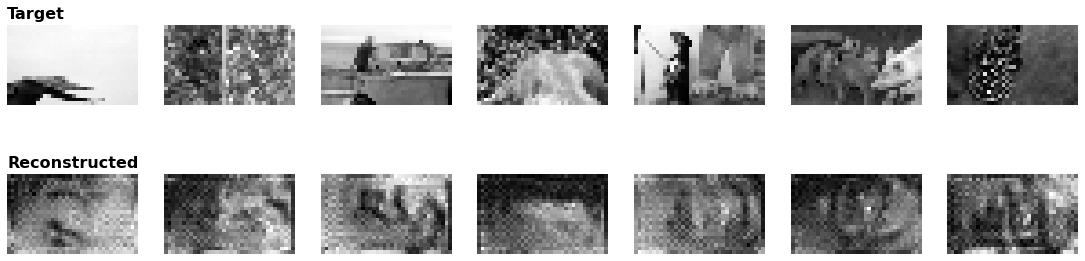

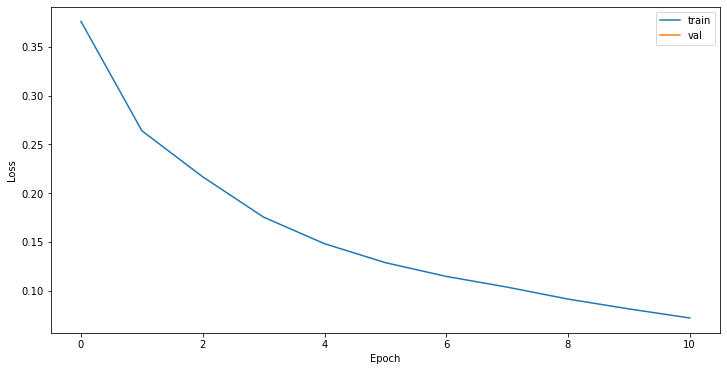

[12/600]
Training progress: [0/373 (0%)]  Loss: 0.056645
Training progress: [100/373 (27%)]  Loss: 0.045108
Training progress: [200/373 (54%)]  Loss: 0.052540
Training progress: [300/373 (80%)]  Loss: 0.064830
train_loss=0.0651


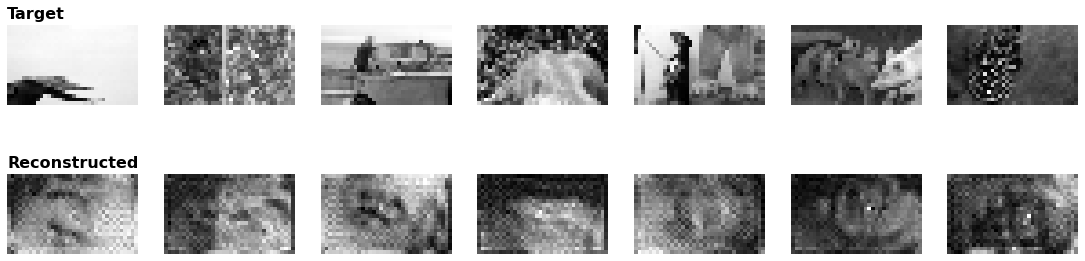

[13/600]
Training progress: [0/373 (0%)]  Loss: 0.053528
Training progress: [100/373 (27%)]  Loss: 0.047779
Training progress: [200/373 (54%)]  Loss: 0.053169
Training progress: [300/373 (80%)]  Loss: 0.060574
train_loss=0.0615


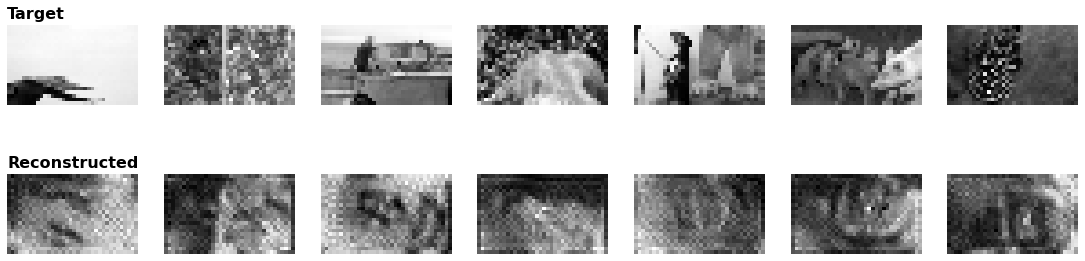

[14/600]
Training progress: [0/373 (0%)]  Loss: 0.077358
Training progress: [100/373 (27%)]  Loss: 0.048071
Training progress: [200/373 (54%)]  Loss: 0.042323
Training progress: [300/373 (80%)]  Loss: 0.062663
train_loss=0.0598


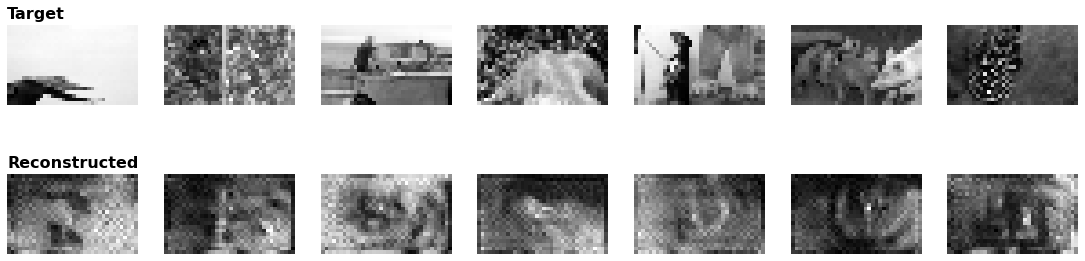

[15/600]
Training progress: [0/373 (0%)]  Loss: 0.068515
Training progress: [100/373 (27%)]  Loss: 0.050849
Training progress: [200/373 (54%)]  Loss: 0.037645
Training progress: [300/373 (80%)]  Loss: 0.048190
train_loss=0.0589


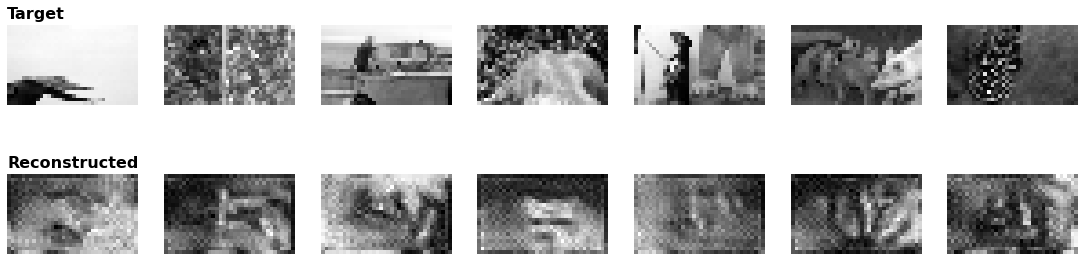

[16/600]
Training progress: [0/373 (0%)]  Loss: 0.052087
Training progress: [100/373 (27%)]  Loss: 0.050106
Training progress: [200/373 (54%)]  Loss: 0.036206
Training progress: [300/373 (80%)]  Loss: 0.054931
train_loss=0.0583


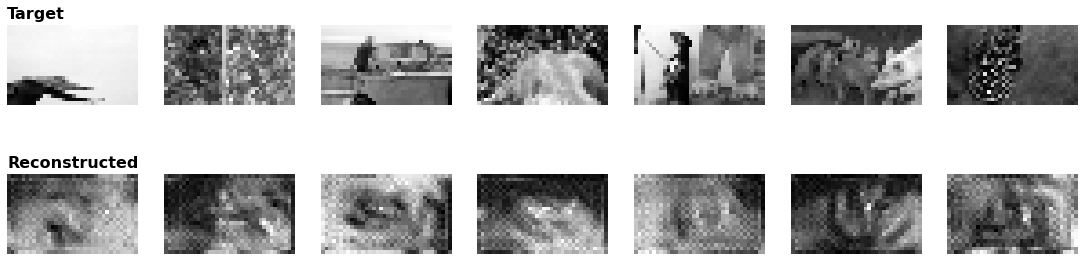

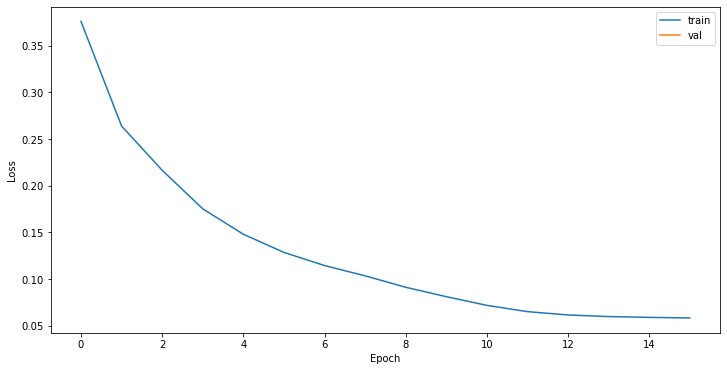

[17/600]
Training progress: [0/373 (0%)]  Loss: 0.039186
Training progress: [100/373 (27%)]  Loss: 0.062397
Training progress: [200/373 (54%)]  Loss: 0.030798
Training progress: [300/373 (80%)]  Loss: 0.059346
train_loss=0.0561


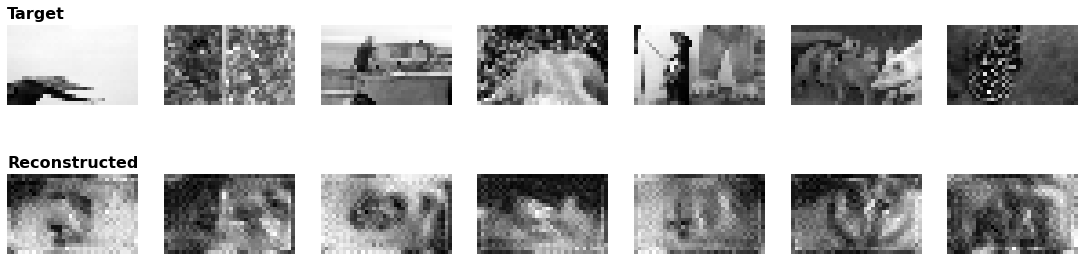

[18/600]
Training progress: [0/373 (0%)]  Loss: 0.040288
Training progress: [100/373 (27%)]  Loss: 0.069039
Training progress: [200/373 (54%)]  Loss: 0.022734
Training progress: [300/373 (80%)]  Loss: 0.083491
train_loss=0.0554


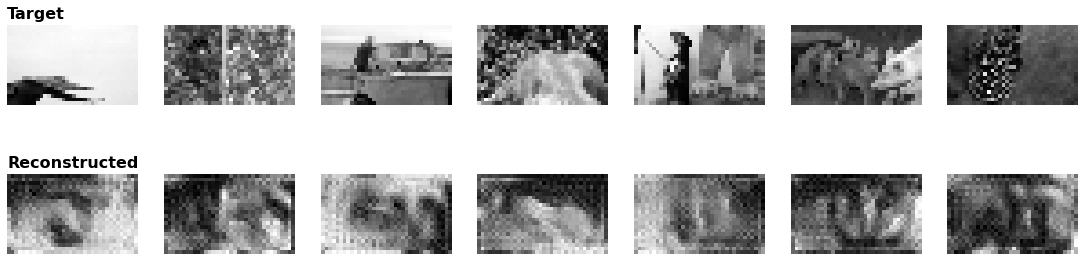

[19/600]
Training progress: [0/373 (0%)]  Loss: 0.043793
Training progress: [100/373 (27%)]  Loss: 0.040503
Training progress: [200/373 (54%)]  Loss: 0.021195
Training progress: [300/373 (80%)]  Loss: 0.062136
train_loss=0.0495


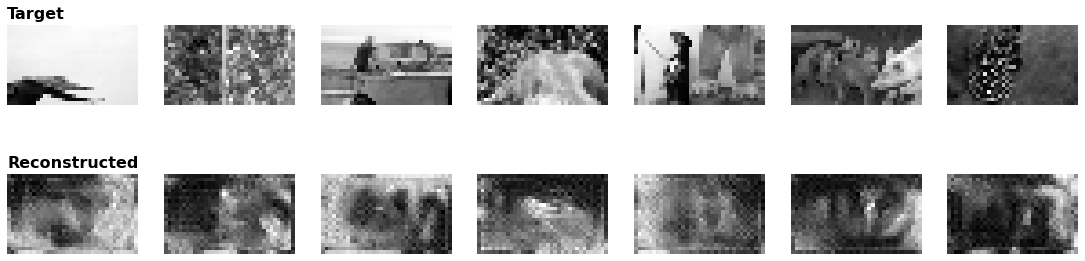

[20/600]
Training progress: [0/373 (0%)]  Loss: 0.058800
Training progress: [100/373 (27%)]  Loss: 0.033460
Training progress: [200/373 (54%)]  Loss: 0.021507
Training progress: [300/373 (80%)]  Loss: 0.059776
train_loss=0.0459


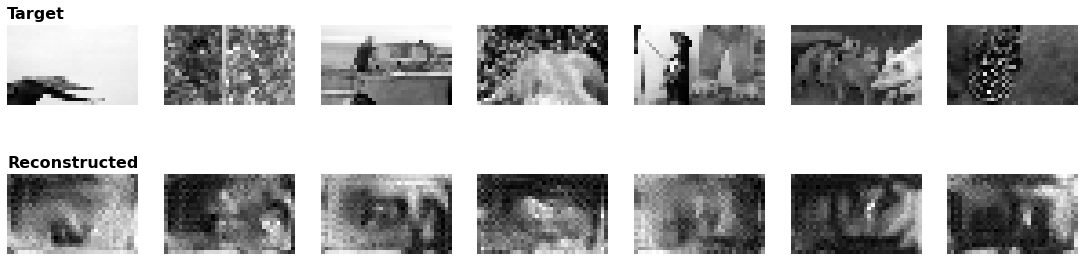

[21/600]
Training progress: [0/373 (0%)]  Loss: 0.055419
Training progress: [100/373 (27%)]  Loss: 0.028368
Training progress: [200/373 (54%)]  Loss: 0.022391
Training progress: [300/373 (80%)]  Loss: 0.063535
train_loss=0.0466


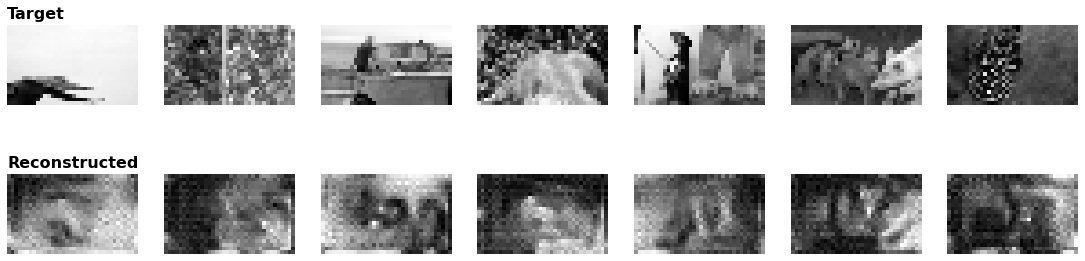

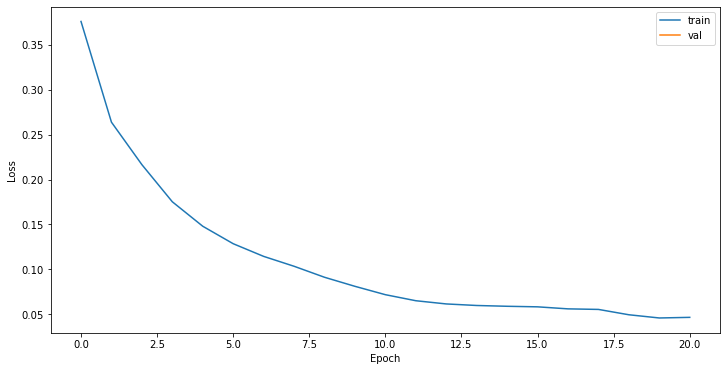

[22/600]
Training progress: [0/373 (0%)]  Loss: 0.031358
Training progress: [100/373 (27%)]  Loss: 0.033374
Training progress: [200/373 (54%)]  Loss: 0.020849
Training progress: [300/373 (80%)]  Loss: 0.043212
train_loss=0.0455


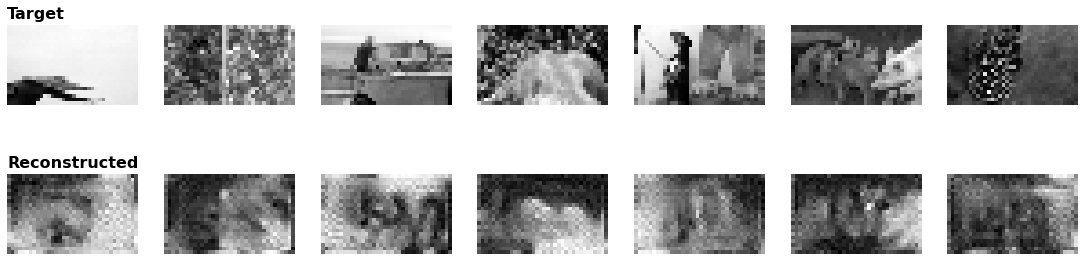

[23/600]
Training progress: [0/373 (0%)]  Loss: 0.042019
Training progress: [100/373 (27%)]  Loss: 0.035240
Training progress: [200/373 (54%)]  Loss: 0.020718
Training progress: [300/373 (80%)]  Loss: 0.032654
train_loss=0.0405


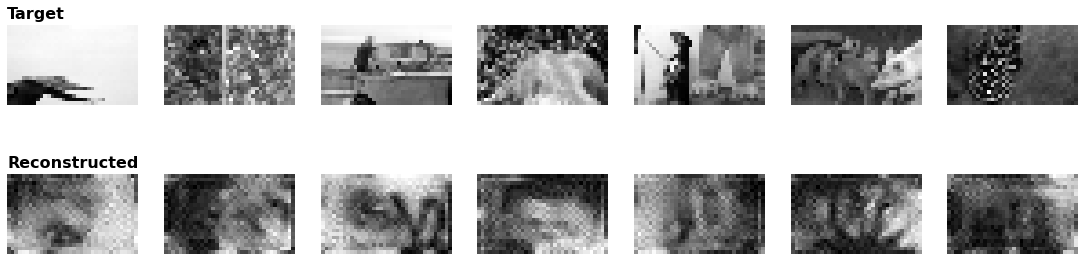

[24/600]
Training progress: [0/373 (0%)]  Loss: 0.038310
Training progress: [100/373 (27%)]  Loss: 0.026791
Training progress: [200/373 (54%)]  Loss: 0.022731
Training progress: [300/373 (80%)]  Loss: 0.028680
train_loss=0.0359


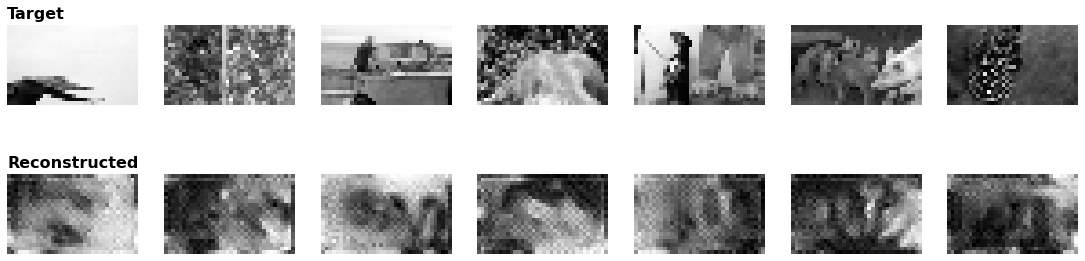

[25/600]
Training progress: [0/373 (0%)]  Loss: 0.031977
Training progress: [100/373 (27%)]  Loss: 0.024785
Training progress: [200/373 (54%)]  Loss: 0.027427
Training progress: [300/373 (80%)]  Loss: 0.033574
train_loss=0.0342


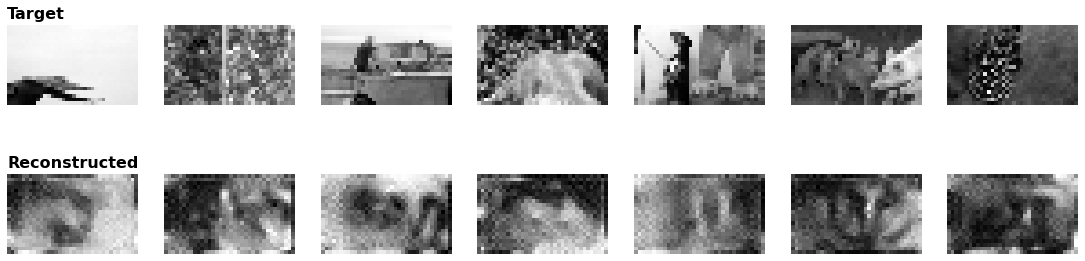

[26/600]
Training progress: [0/373 (0%)]  Loss: 0.028427
Training progress: [100/373 (27%)]  Loss: 0.027496
Training progress: [200/373 (54%)]  Loss: 0.021360
Training progress: [300/373 (80%)]  Loss: 0.031817
train_loss=0.0337


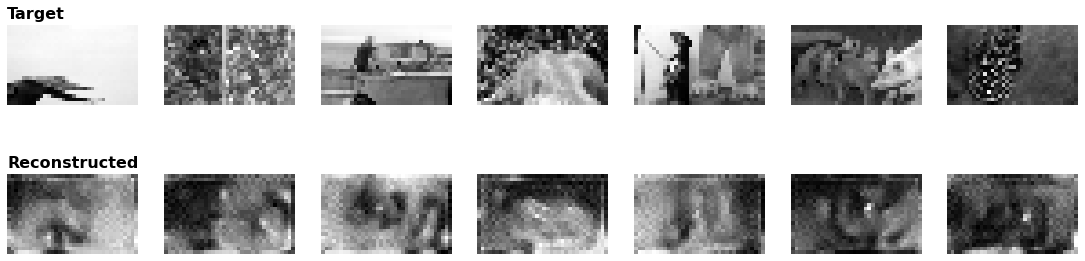

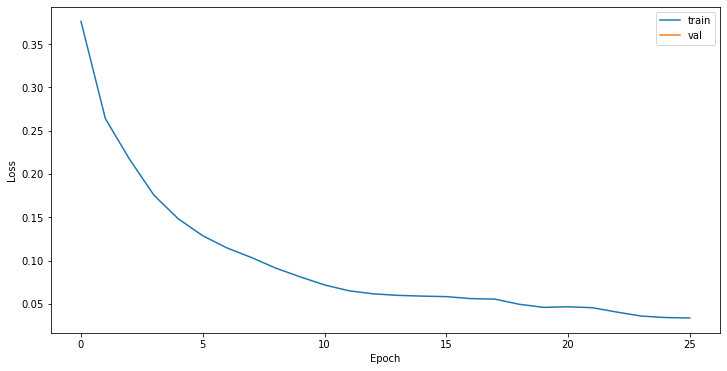

[27/600]
Training progress: [0/373 (0%)]  Loss: 0.025006
Training progress: [100/373 (27%)]  Loss: 0.025325
Training progress: [200/373 (54%)]  Loss: 0.027361
Training progress: [300/373 (80%)]  Loss: 0.028564
train_loss=0.0351


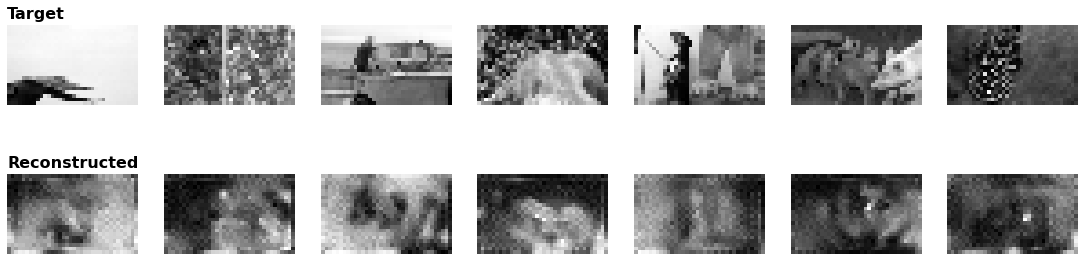

[28/600]
Training progress: [0/373 (0%)]  Loss: 0.022394
Training progress: [100/373 (27%)]  Loss: 0.027158
Training progress: [200/373 (54%)]  Loss: 0.024088
Training progress: [300/373 (80%)]  Loss: 0.025303
train_loss=0.0360


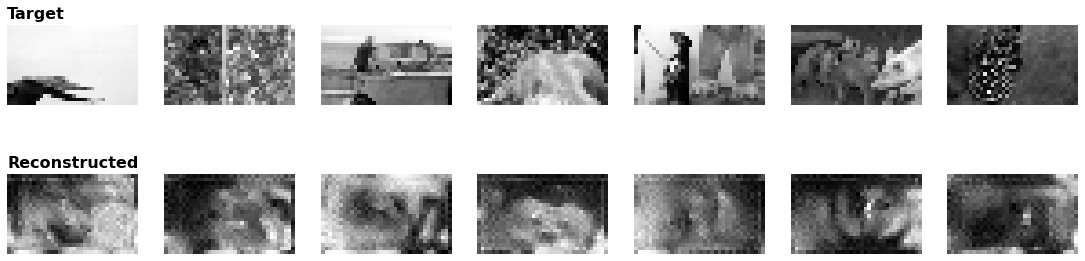

[29/600]
Training progress: [0/373 (0%)]  Loss: 0.023230
Training progress: [100/373 (27%)]  Loss: 0.025439
Training progress: [200/373 (54%)]  Loss: 0.019478
Training progress: [300/373 (80%)]  Loss: 0.026862
train_loss=0.0358


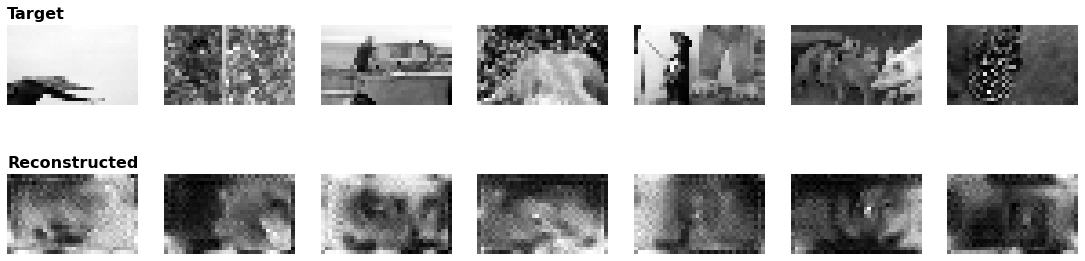

[30/600]
Training progress: [0/373 (0%)]  Loss: 0.024058
Training progress: [100/373 (27%)]  Loss: 0.046326
Training progress: [200/373 (54%)]  Loss: 0.017205
Training progress: [300/373 (80%)]  Loss: 0.032995
train_loss=0.0346


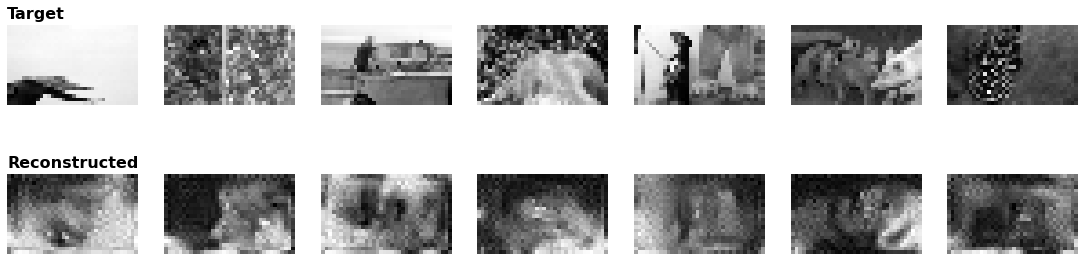

[31/600]
Training progress: [0/373 (0%)]  Loss: 0.026637
Training progress: [100/373 (27%)]  Loss: 0.044272
Training progress: [200/373 (54%)]  Loss: 0.019887
Training progress: [300/373 (80%)]  Loss: 0.049841
train_loss=0.0332


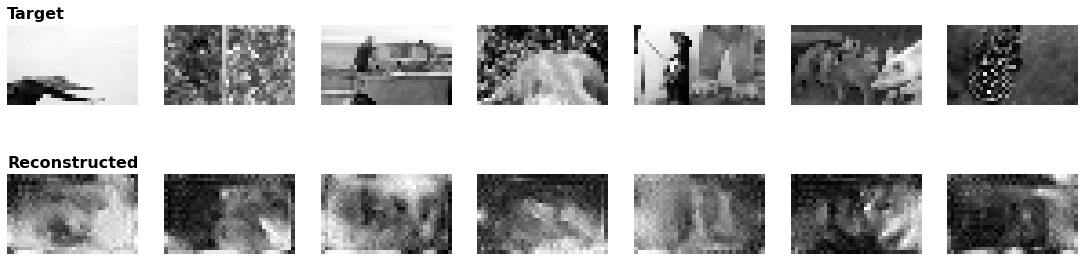

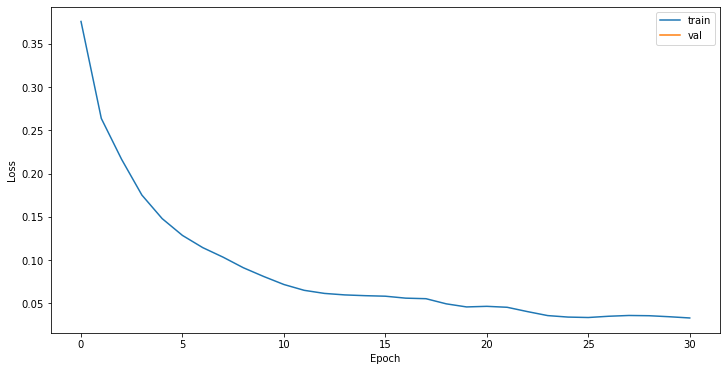

[32/600]
Training progress: [0/373 (0%)]  Loss: 0.020465
Training progress: [100/373 (27%)]  Loss: 0.031759
Training progress: [200/373 (54%)]  Loss: 0.023920
Training progress: [300/373 (80%)]  Loss: 0.038161
train_loss=0.0321


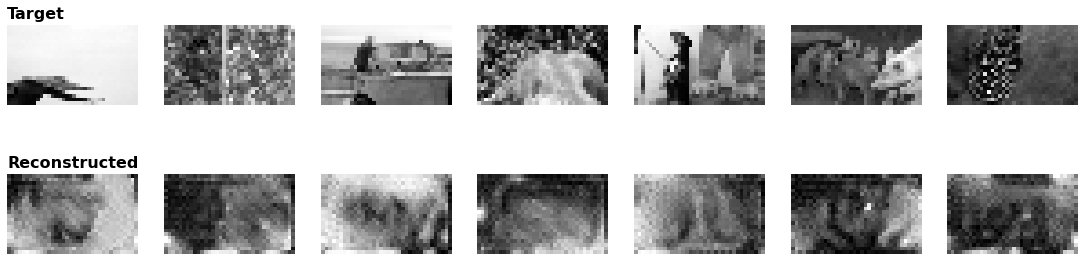

[33/600]
Training progress: [0/373 (0%)]  Loss: 0.035901
Training progress: [100/373 (27%)]  Loss: 0.020655
Training progress: [200/373 (54%)]  Loss: 0.021373
Training progress: [300/373 (80%)]  Loss: 0.021973
train_loss=0.0306


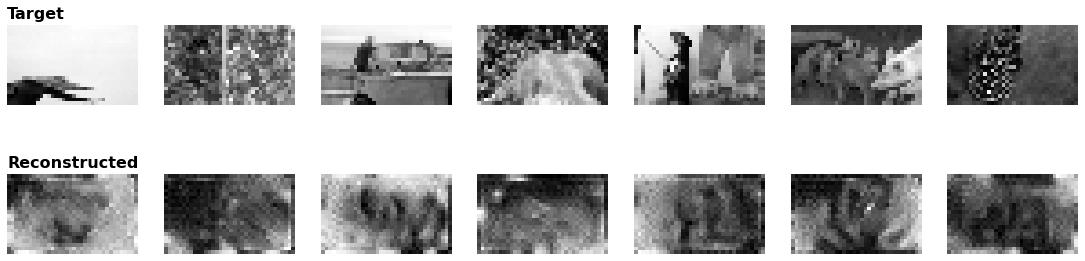

[34/600]
Training progress: [0/373 (0%)]  Loss: 0.032811
Training progress: [100/373 (27%)]  Loss: 0.022232
Training progress: [200/373 (54%)]  Loss: 0.017256
Training progress: [300/373 (80%)]  Loss: 0.021493
train_loss=0.0294


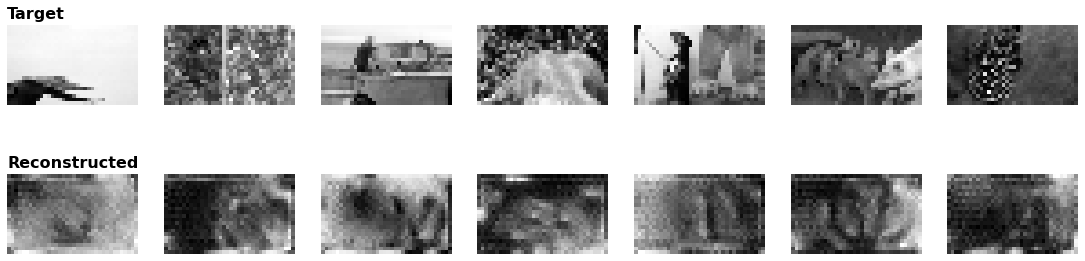

[35/600]
Training progress: [0/373 (0%)]  Loss: 0.029120
Training progress: [100/373 (27%)]  Loss: 0.019111
Training progress: [200/373 (54%)]  Loss: 0.013517
Training progress: [300/373 (80%)]  Loss: 0.030095
train_loss=0.0287


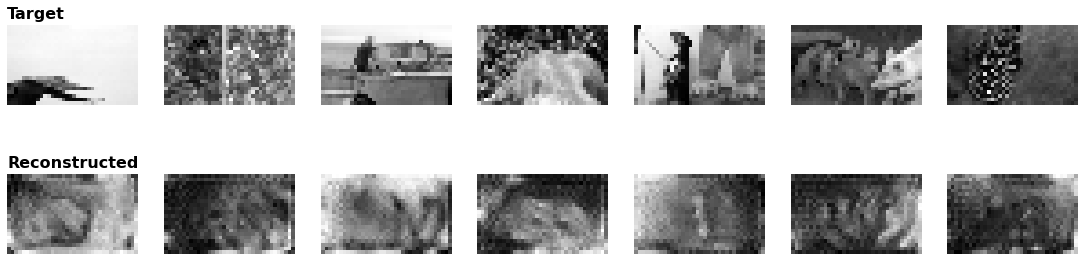

[36/600]
Training progress: [0/373 (0%)]  Loss: 0.040677
Training progress: [100/373 (27%)]  Loss: 0.016272
Training progress: [200/373 (54%)]  Loss: 0.017995
Training progress: [300/373 (80%)]  Loss: 0.026635
train_loss=0.0294


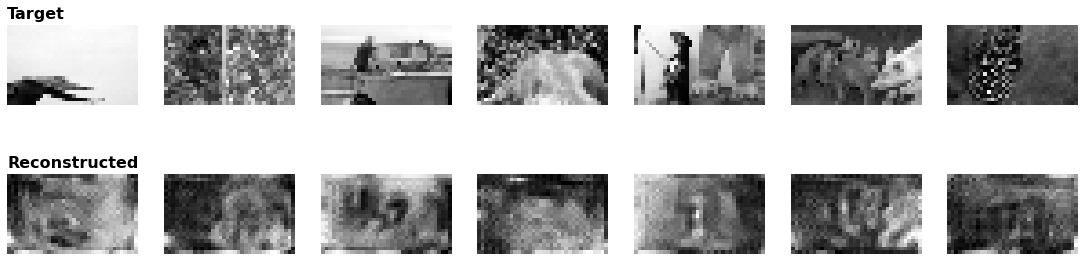

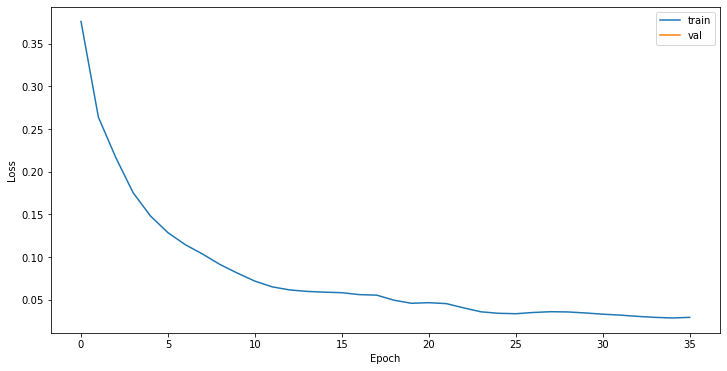

[37/600]
Training progress: [0/373 (0%)]  Loss: 0.038880
Training progress: [100/373 (27%)]  Loss: 0.017525
Training progress: [200/373 (54%)]  Loss: 0.023201
Training progress: [300/373 (80%)]  Loss: 0.027640
train_loss=0.0311


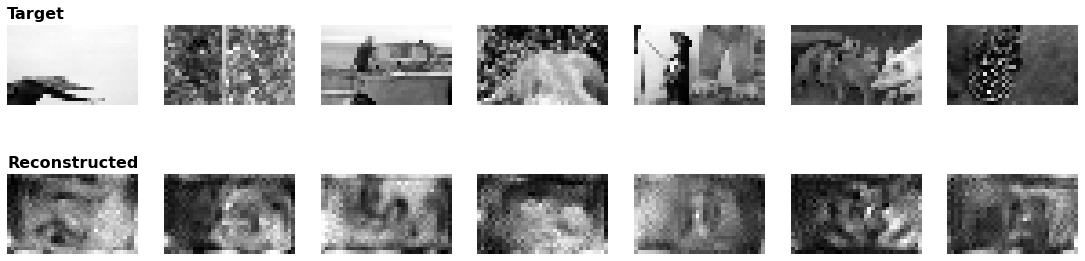

[38/600]
Training progress: [0/373 (0%)]  Loss: 0.033674
Training progress: [100/373 (27%)]  Loss: 0.020809
Training progress: [200/373 (54%)]  Loss: 0.016045
Training progress: [300/373 (80%)]  Loss: 0.025701
train_loss=0.0343


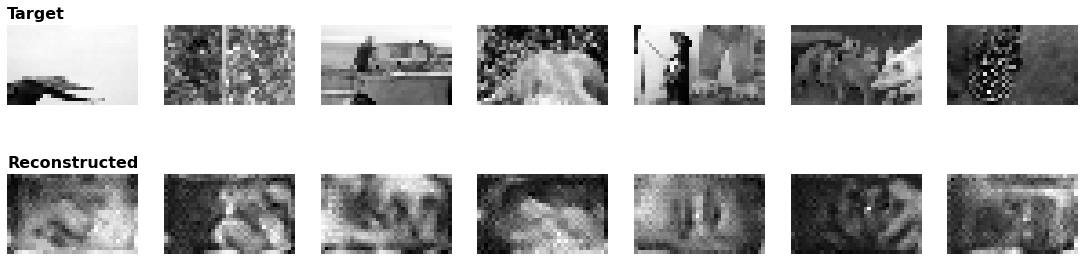

[39/600]
Training progress: [0/373 (0%)]  Loss: 0.033604
Training progress: [100/373 (27%)]  Loss: 0.020472
Training progress: [200/373 (54%)]  Loss: 0.013445
Training progress: [300/373 (80%)]  Loss: 0.024278
train_loss=0.0349


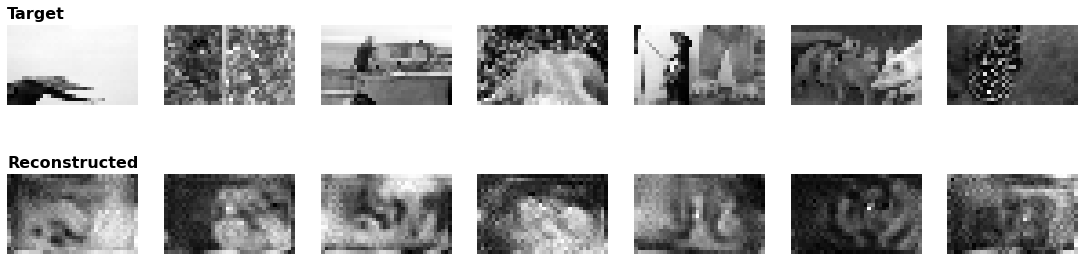

[40/600]
Training progress: [0/373 (0%)]  Loss: 0.025923
Training progress: [100/373 (27%)]  Loss: 0.027419
Training progress: [200/373 (54%)]  Loss: 0.014697
Training progress: [300/373 (80%)]  Loss: 0.035807
train_loss=0.0319


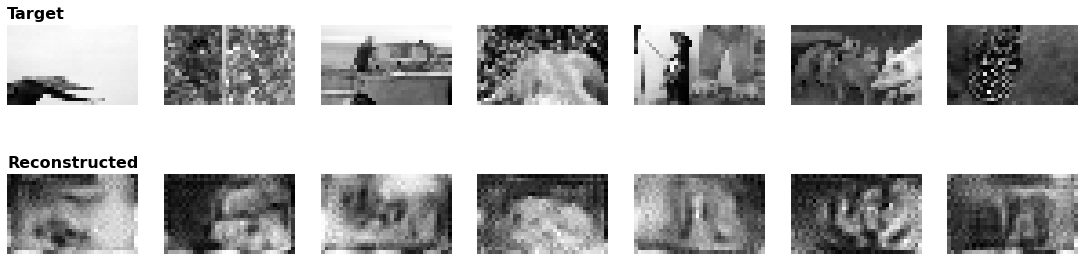

[41/600]
Training progress: [0/373 (0%)]  Loss: 0.023344
Training progress: [100/373 (27%)]  Loss: 0.019791
Training progress: [200/373 (54%)]  Loss: 0.015046
Training progress: [300/373 (80%)]  Loss: 0.035089
train_loss=0.0270


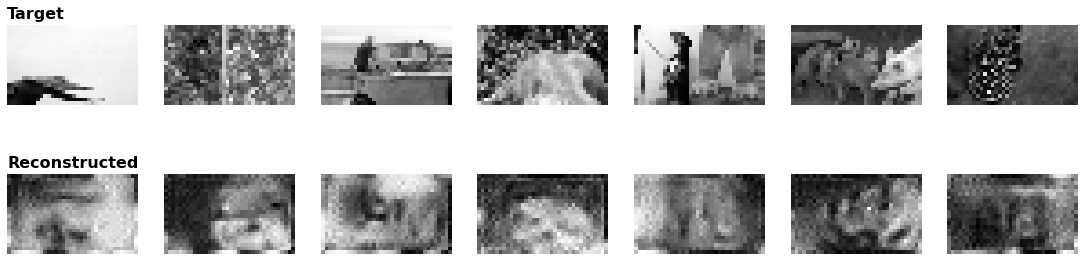

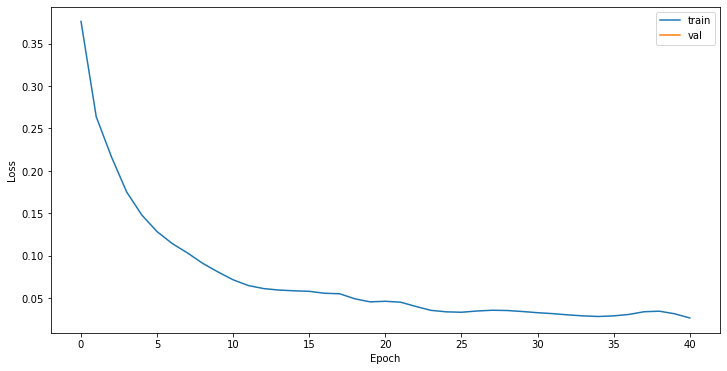

[42/600]
Training progress: [0/373 (0%)]  Loss: 0.021918
Training progress: [100/373 (27%)]  Loss: 0.017587
Training progress: [200/373 (54%)]  Loss: 0.011806
Training progress: [300/373 (80%)]  Loss: 0.022892
train_loss=0.0235


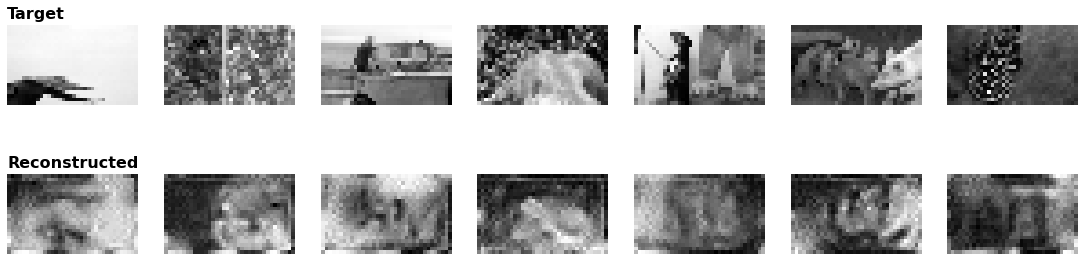

[43/600]
Training progress: [0/373 (0%)]  Loss: 0.018626
Training progress: [100/373 (27%)]  Loss: 0.026174
Training progress: [200/373 (54%)]  Loss: 0.010536
Training progress: [300/373 (80%)]  Loss: 0.018027
train_loss=0.0221


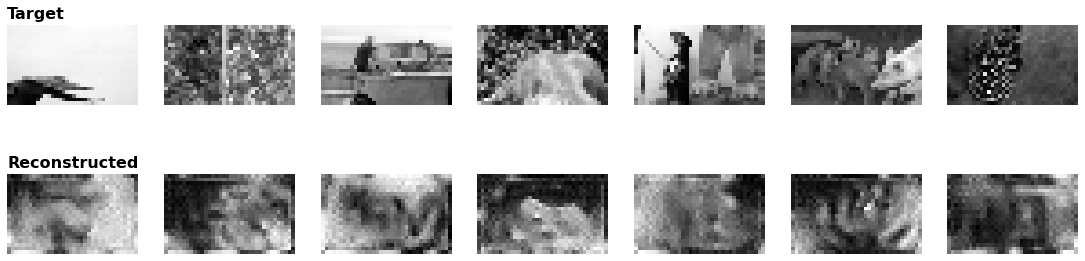

[44/600]
Training progress: [0/373 (0%)]  Loss: 0.022424
Training progress: [100/373 (27%)]  Loss: 0.017359
Training progress: [200/373 (54%)]  Loss: 0.008984
Training progress: [300/373 (80%)]  Loss: 0.017058
train_loss=0.0220


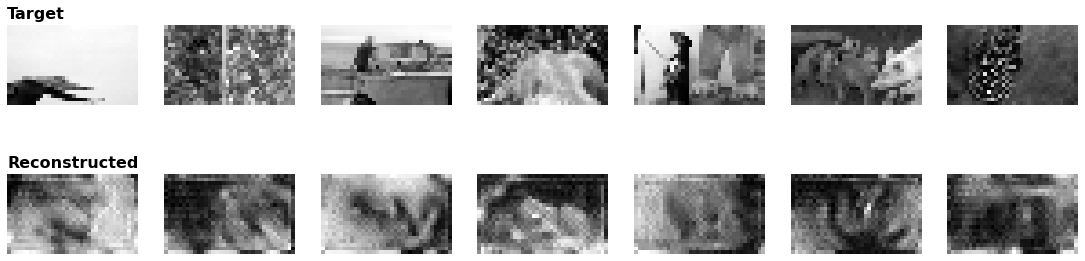

[45/600]
Training progress: [0/373 (0%)]  Loss: 0.023378
Training progress: [100/373 (27%)]  Loss: 0.013237
Training progress: [200/373 (54%)]  Loss: 0.011170
Training progress: [300/373 (80%)]  Loss: 0.017548
train_loss=0.0231


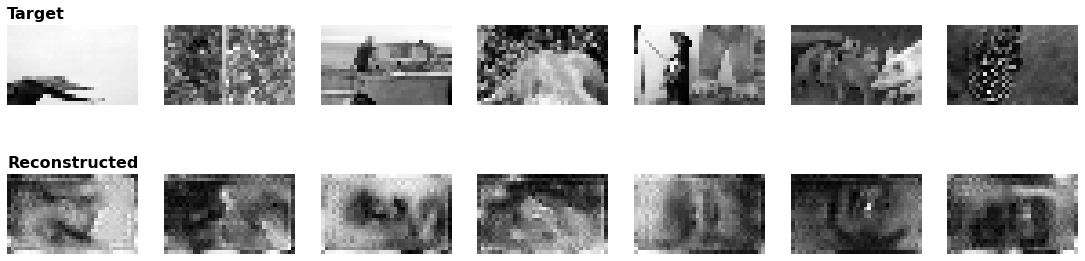

[46/600]
Training progress: [0/373 (0%)]  Loss: 0.018807
Training progress: [100/373 (27%)]  Loss: 0.012915
Training progress: [200/373 (54%)]  Loss: 0.011922
Training progress: [300/373 (80%)]  Loss: 0.018283
train_loss=0.0236


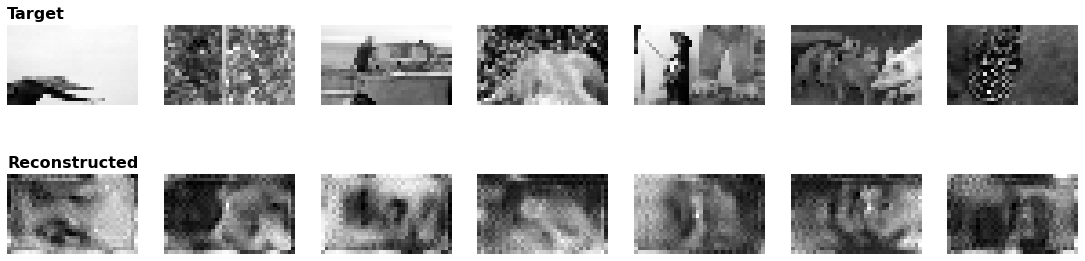

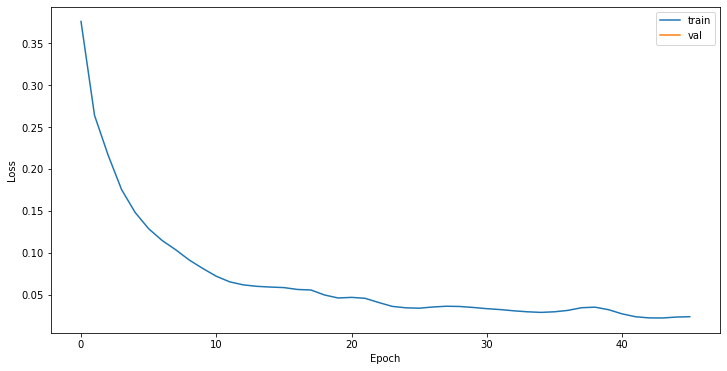

[47/600]
Training progress: [0/373 (0%)]  Loss: 0.030241
Training progress: [100/373 (27%)]  Loss: 0.014100
Training progress: [200/373 (54%)]  Loss: 0.014177
Training progress: [300/373 (80%)]  Loss: 0.018958
train_loss=0.0236


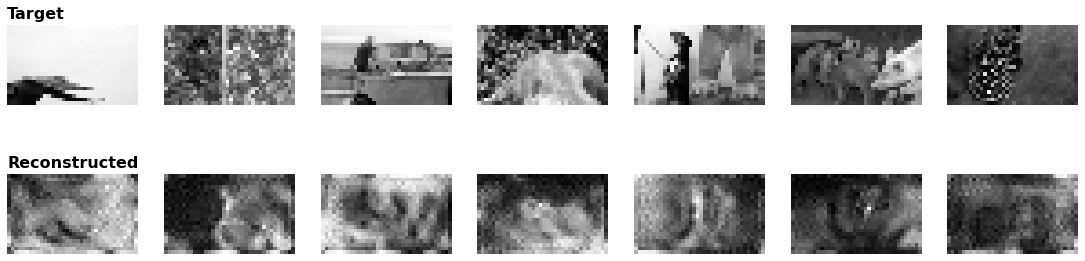

[48/600]
Training progress: [0/373 (0%)]  Loss: 0.037386
Training progress: [100/373 (27%)]  Loss: 0.014180
Training progress: [200/373 (54%)]  Loss: 0.013088
Training progress: [300/373 (80%)]  Loss: 0.029112
train_loss=0.0239


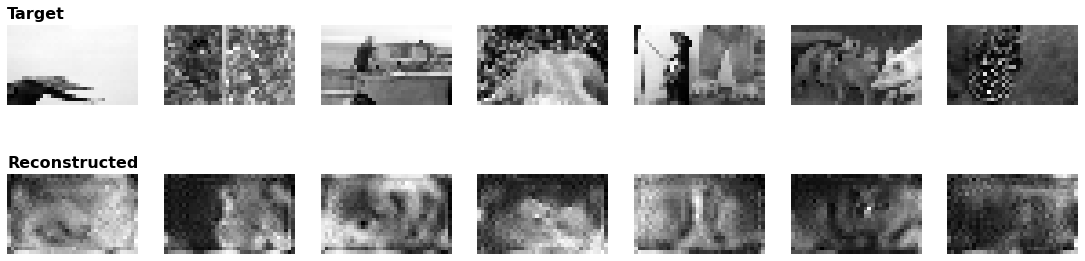

[49/600]
Training progress: [0/373 (0%)]  Loss: 0.030409
Training progress: [100/373 (27%)]  Loss: 0.017692
Training progress: [200/373 (54%)]  Loss: 0.011839
Training progress: [300/373 (80%)]  Loss: 0.023534
train_loss=0.0239


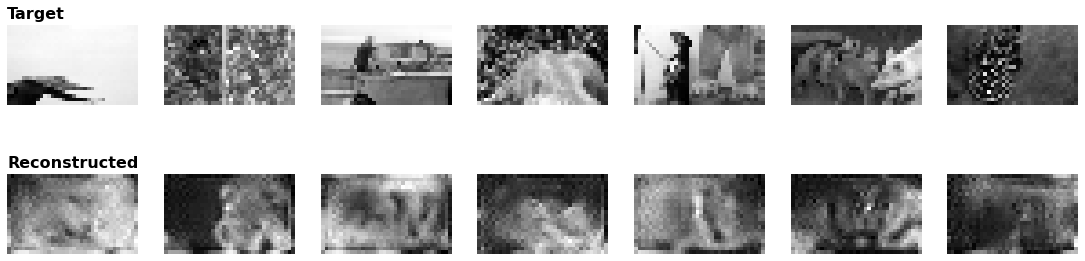

[50/600]
Training progress: [0/373 (0%)]  Loss: 0.018895
Training progress: [100/373 (27%)]  Loss: 0.026075
Training progress: [200/373 (54%)]  Loss: 0.010773
Training progress: [300/373 (80%)]  Loss: 0.021069
train_loss=0.0233


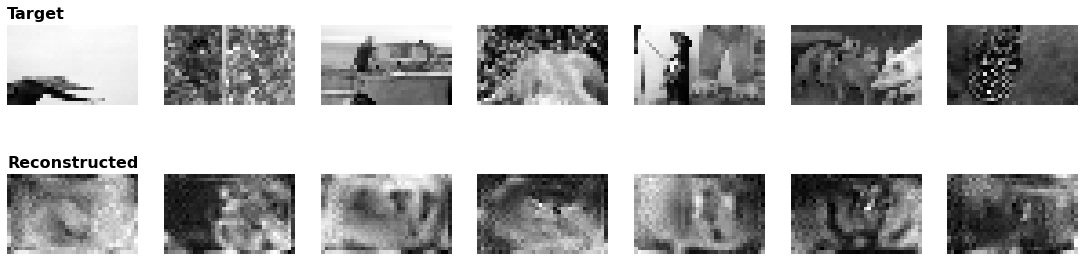

[51/600]
Training progress: [0/373 (0%)]  Loss: 0.016020
Training progress: [100/373 (27%)]  Loss: 0.018982
Training progress: [200/373 (54%)]  Loss: 0.014232
Training progress: [300/373 (80%)]  Loss: 0.016020
train_loss=0.0216


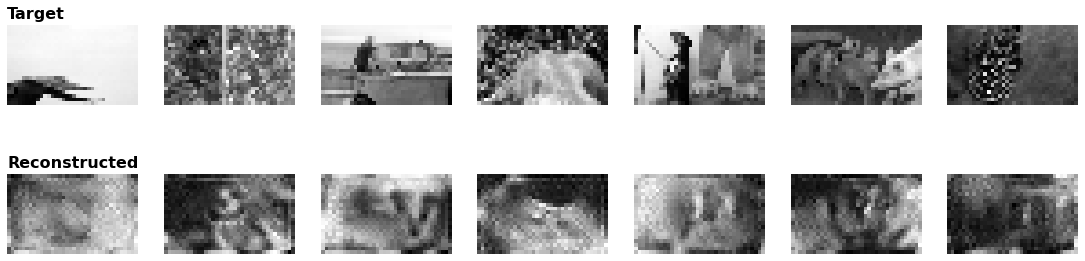

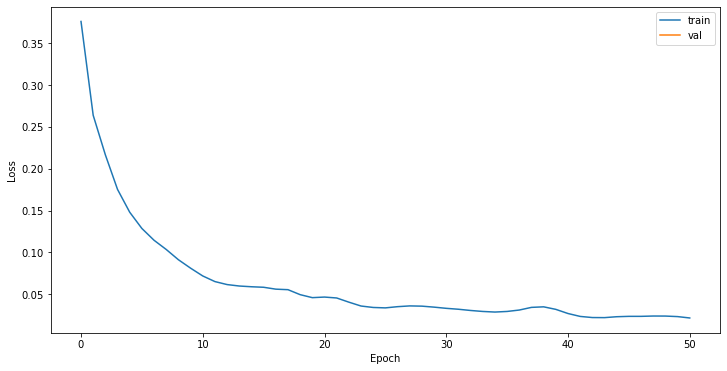

[52/600]
Training progress: [0/373 (0%)]  Loss: 0.014299
Training progress: [100/373 (27%)]  Loss: 0.013590
Training progress: [200/373 (54%)]  Loss: 0.015463
Training progress: [300/373 (80%)]  Loss: 0.016720
train_loss=0.0202


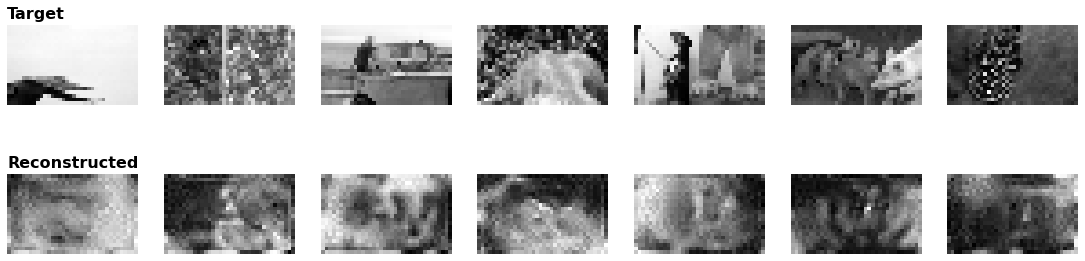

[53/600]
Training progress: [0/373 (0%)]  Loss: 0.011114
Training progress: [100/373 (27%)]  Loss: 0.031007
Training progress: [200/373 (54%)]  Loss: 0.010204
Training progress: [300/373 (80%)]  Loss: 0.020309
train_loss=0.0191


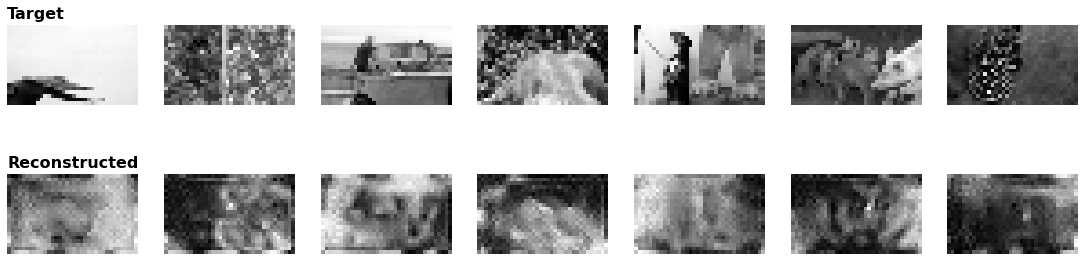

[54/600]
Training progress: [0/373 (0%)]  Loss: 0.010579
Training progress: [100/373 (27%)]  Loss: 0.016364
Training progress: [200/373 (54%)]  Loss: 0.011499
Training progress: [300/373 (80%)]  Loss: 0.020982
train_loss=0.0182


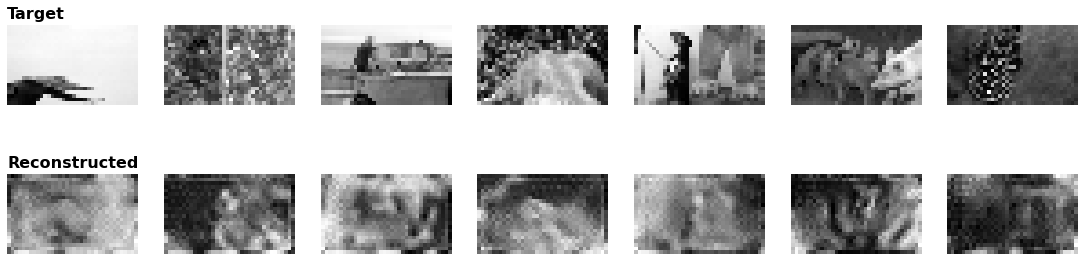

[55/600]
Training progress: [0/373 (0%)]  Loss: 0.010267
Training progress: [100/373 (27%)]  Loss: 0.014972
Training progress: [200/373 (54%)]  Loss: 0.012802
Training progress: [300/373 (80%)]  Loss: 0.022876
train_loss=0.0185


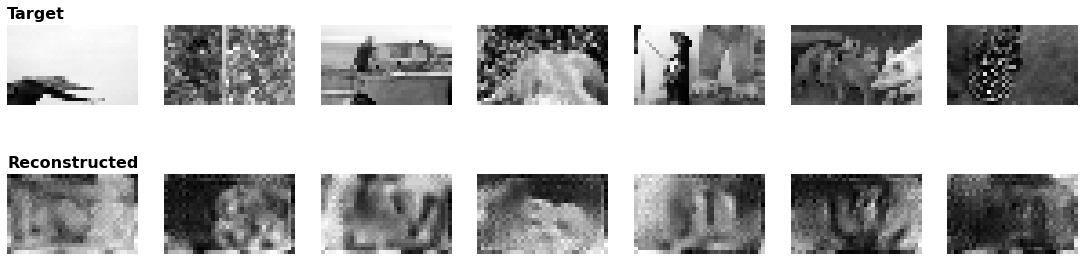

[56/600]
Training progress: [0/373 (0%)]  Loss: 0.009956
Training progress: [100/373 (27%)]  Loss: 0.020098
Training progress: [200/373 (54%)]  Loss: 0.011973
Training progress: [300/373 (80%)]  Loss: 0.017570
train_loss=0.0193


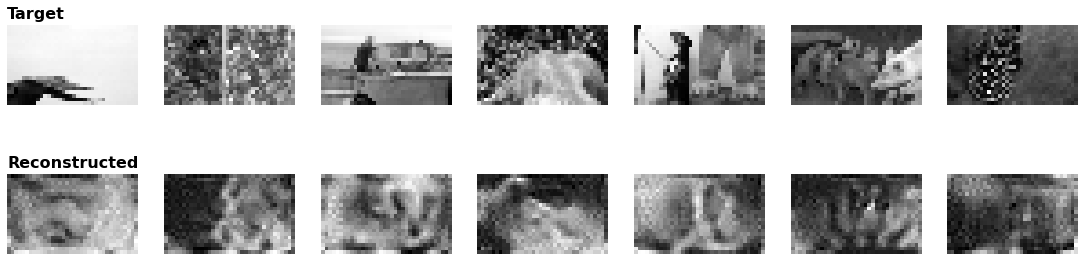

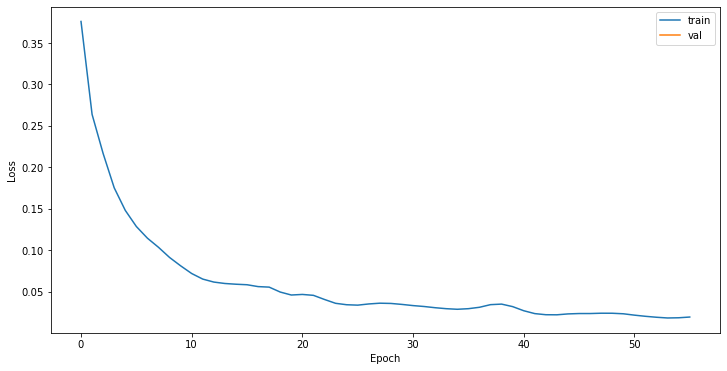

[57/600]
Training progress: [0/373 (0%)]  Loss: 0.013474
Training progress: [100/373 (27%)]  Loss: 0.017002
Training progress: [200/373 (54%)]  Loss: 0.012585
Training progress: [300/373 (80%)]  Loss: 0.017481
train_loss=0.0198


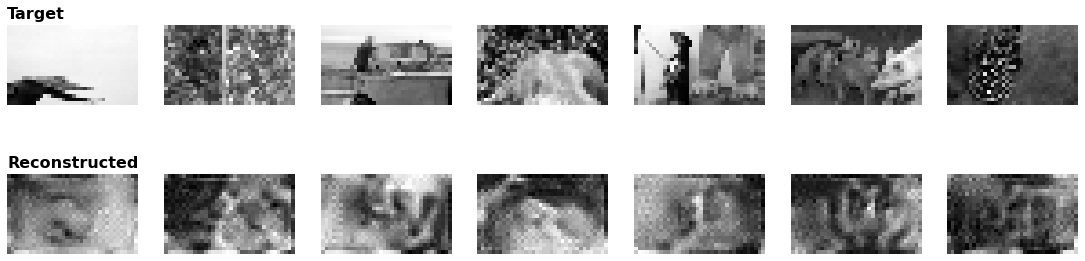

[58/600]
Training progress: [0/373 (0%)]  Loss: 0.024528
Training progress: [100/373 (27%)]  Loss: 0.019665
Training progress: [200/373 (54%)]  Loss: 0.012958
Training progress: [300/373 (80%)]  Loss: 0.016526
train_loss=0.0189


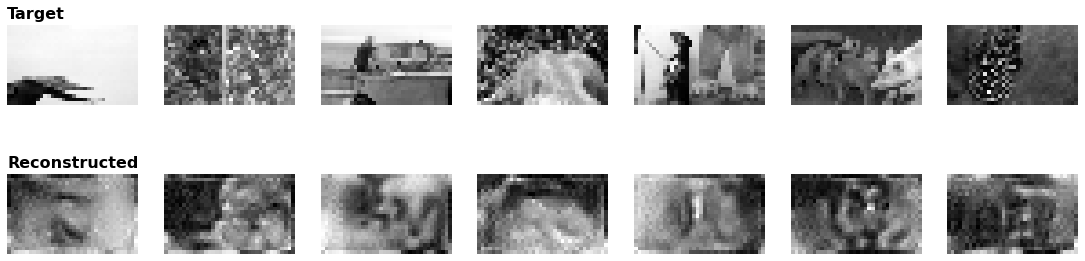

[59/600]
Training progress: [0/373 (0%)]  Loss: 0.021848
Training progress: [100/373 (27%)]  Loss: 0.017018
Training progress: [200/373 (54%)]  Loss: 0.015052
Training progress: [300/373 (80%)]  Loss: 0.015391
train_loss=0.0179


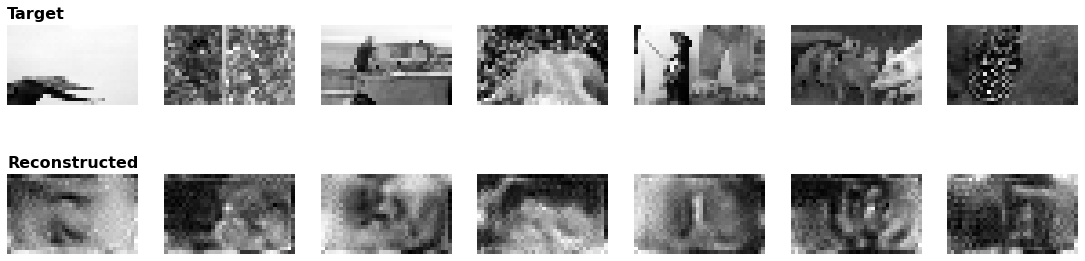

[60/600]
Training progress: [0/373 (0%)]  Loss: 0.018394
Training progress: [100/373 (27%)]  Loss: 0.012226
Training progress: [200/373 (54%)]  Loss: 0.018395
Training progress: [300/373 (80%)]  Loss: 0.011900
train_loss=0.0173


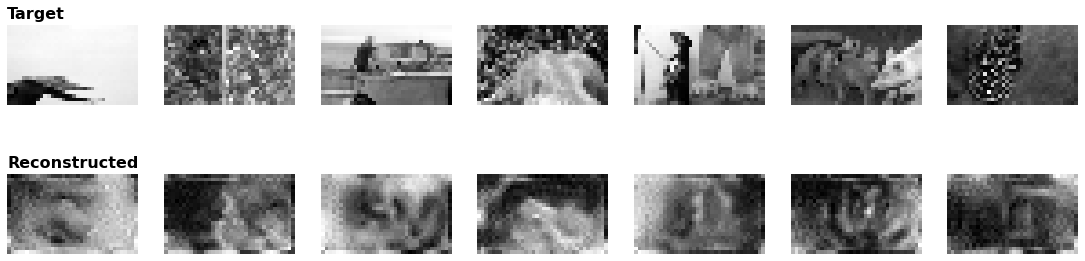

[61/600]
Training progress: [0/373 (0%)]  Loss: 0.017241
Training progress: [100/373 (27%)]  Loss: 0.010928
Training progress: [200/373 (54%)]  Loss: 0.011878
Training progress: [300/373 (80%)]  Loss: 0.017557
train_loss=0.0161


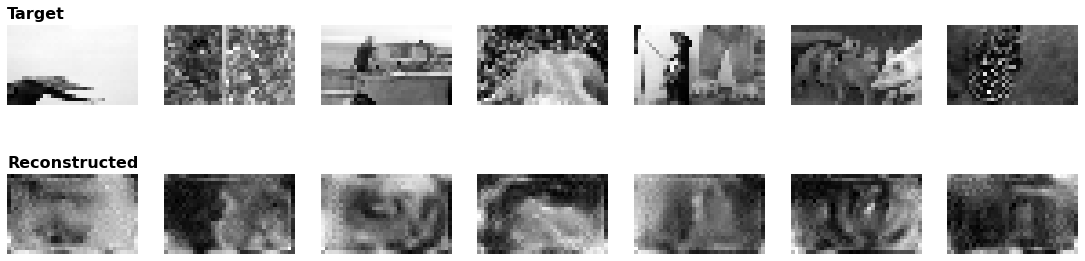

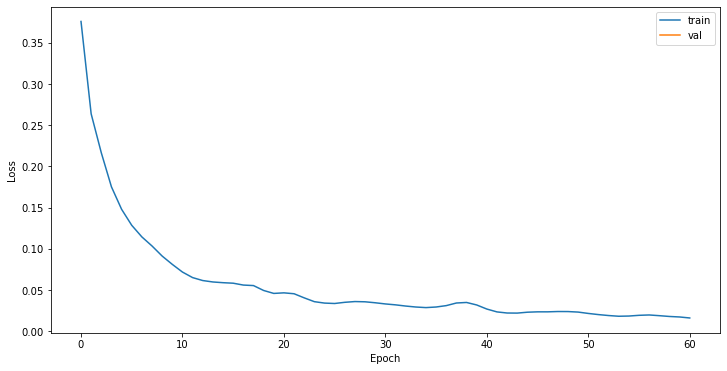

[62/600]
Training progress: [0/373 (0%)]  Loss: 0.017545
Training progress: [100/373 (27%)]  Loss: 0.011478
Training progress: [200/373 (54%)]  Loss: 0.009746
Training progress: [300/373 (80%)]  Loss: 0.015991
train_loss=0.0161


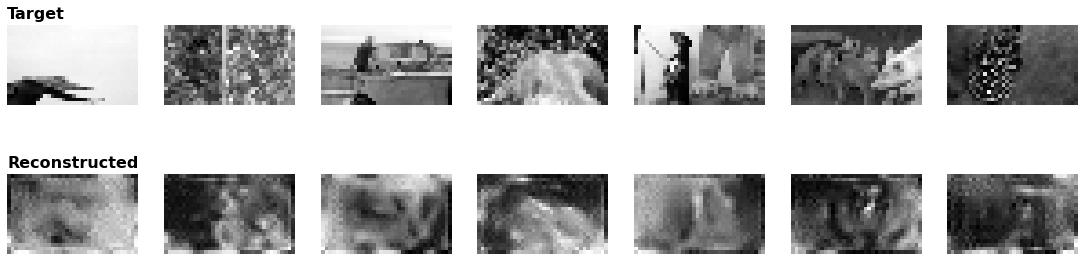

[63/600]
Training progress: [0/373 (0%)]  Loss: 0.013789
Training progress: [100/373 (27%)]  Loss: 0.019232
Training progress: [200/373 (54%)]  Loss: 0.009994
Training progress: [300/373 (80%)]  Loss: 0.012290
train_loss=0.0167


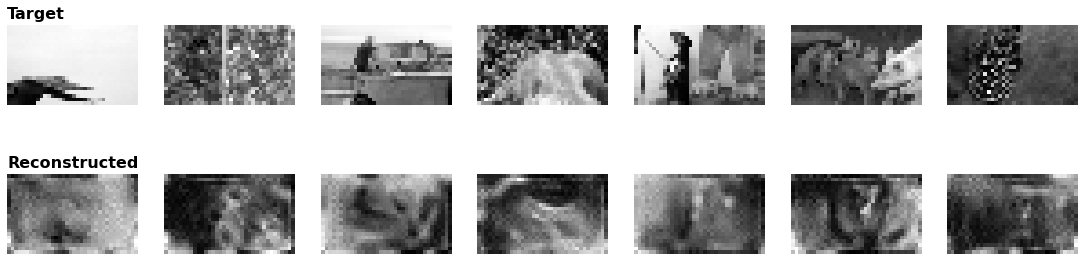

[64/600]
Training progress: [0/373 (0%)]  Loss: 0.015432
Training progress: [100/373 (27%)]  Loss: 0.022728
Training progress: [200/373 (54%)]  Loss: 0.009623
Training progress: [300/373 (80%)]  Loss: 0.018883
train_loss=0.0178


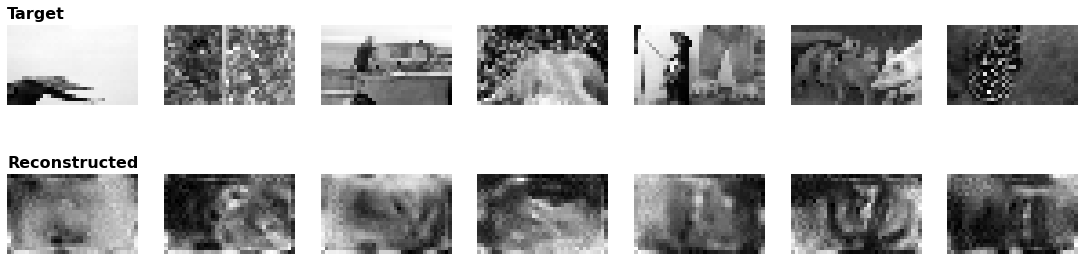

[65/600]
Training progress: [0/373 (0%)]  Loss: 0.011169
Training progress: [100/373 (27%)]  Loss: 0.021640
Training progress: [200/373 (54%)]  Loss: 0.010089
Training progress: [300/373 (80%)]  Loss: 0.021779
train_loss=0.0188


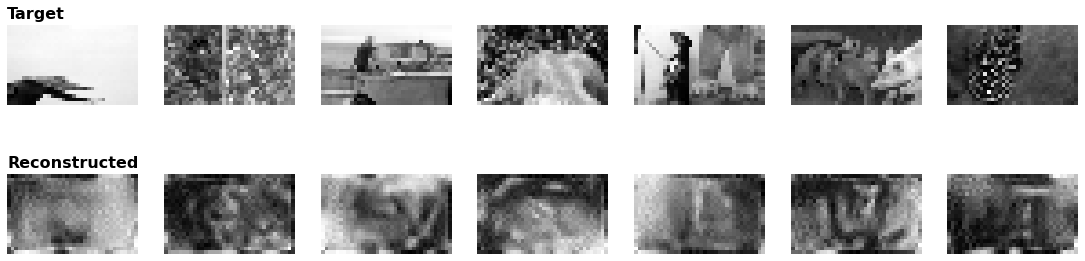

[66/600]
Training progress: [0/373 (0%)]  Loss: 0.018046
Training progress: [100/373 (27%)]  Loss: 0.017613
Training progress: [200/373 (54%)]  Loss: 0.010406
Training progress: [300/373 (80%)]  Loss: 0.013143
train_loss=0.0193


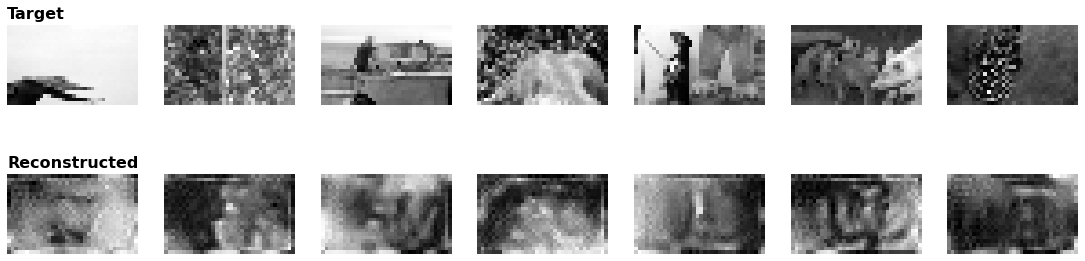

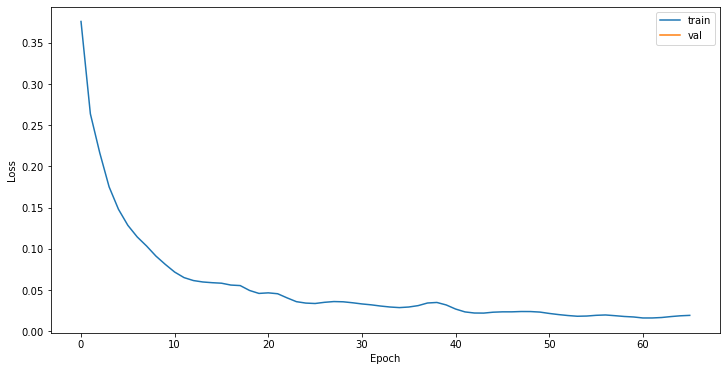

[67/600]
Training progress: [0/373 (0%)]  Loss: 0.025200
Training progress: [100/373 (27%)]  Loss: 0.034949
Training progress: [200/373 (54%)]  Loss: 0.015518
Training progress: [300/373 (80%)]  Loss: 0.017753
train_loss=0.0198


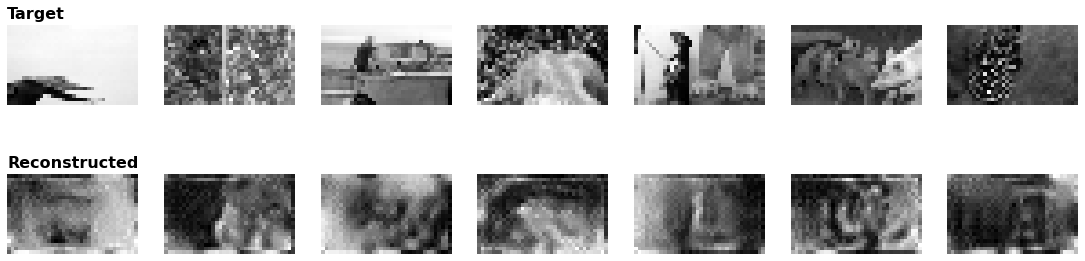

[68/600]
Training progress: [0/373 (0%)]  Loss: 0.020161
Training progress: [100/373 (27%)]  Loss: 0.016300
Training progress: [200/373 (54%)]  Loss: 0.012502
Training progress: [300/373 (80%)]  Loss: 0.011170
train_loss=0.0197


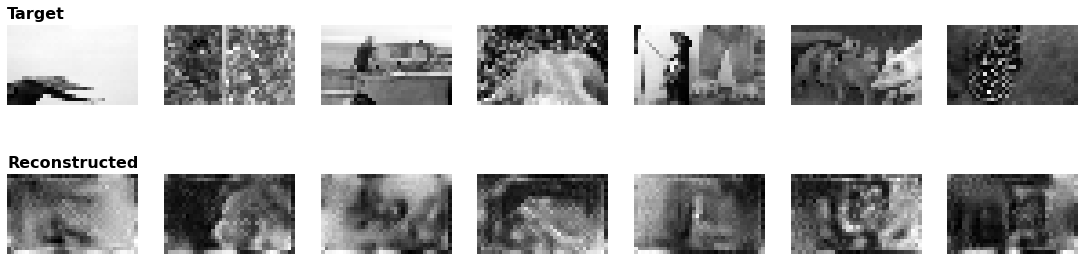

[69/600]
Training progress: [0/373 (0%)]  Loss: 0.014047
Training progress: [100/373 (27%)]  Loss: 0.011905
Training progress: [200/373 (54%)]  Loss: 0.012107
Training progress: [300/373 (80%)]  Loss: 0.014255
train_loss=0.0192


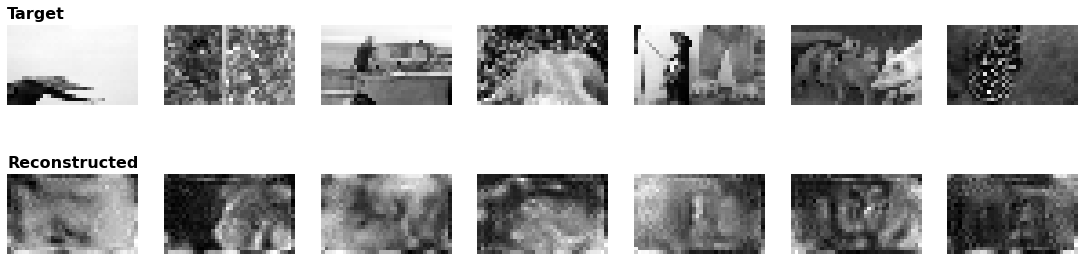

[70/600]
Training progress: [0/373 (0%)]  Loss: 0.021244
Training progress: [100/373 (27%)]  Loss: 0.011033
Training progress: [200/373 (54%)]  Loss: 0.010532
Training progress: [300/373 (80%)]  Loss: 0.014984
train_loss=0.0189


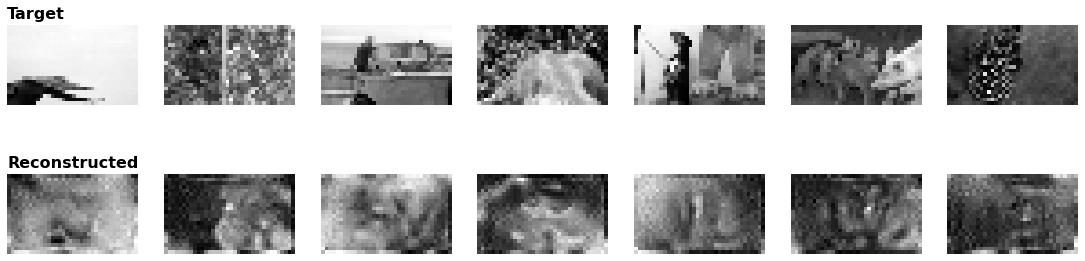

[71/600]
Training progress: [0/373 (0%)]  Loss: 0.014648
Training progress: [100/373 (27%)]  Loss: 0.018549
Training progress: [200/373 (54%)]  Loss: 0.011282
Training progress: [300/373 (80%)]  Loss: 0.013884
train_loss=0.0175


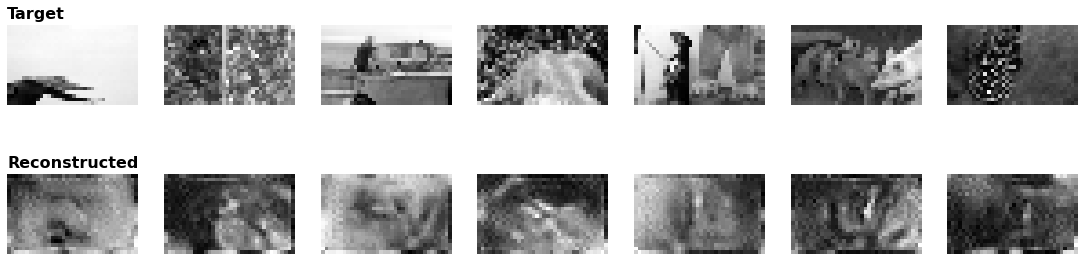

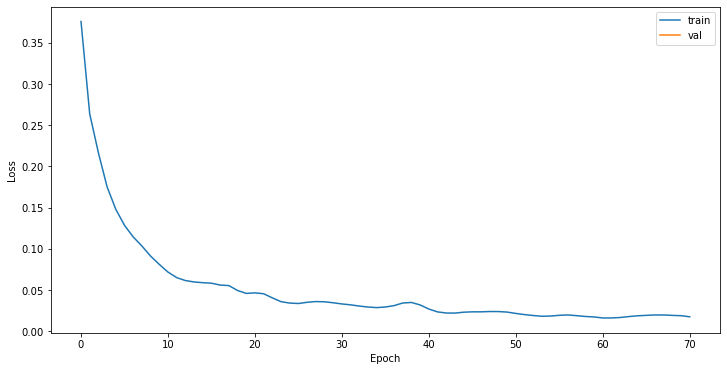

[72/600]
Training progress: [0/373 (0%)]  Loss: 0.015409
Training progress: [100/373 (27%)]  Loss: 0.012821
Training progress: [200/373 (54%)]  Loss: 0.012451
Training progress: [300/373 (80%)]  Loss: 0.017027
train_loss=0.0158


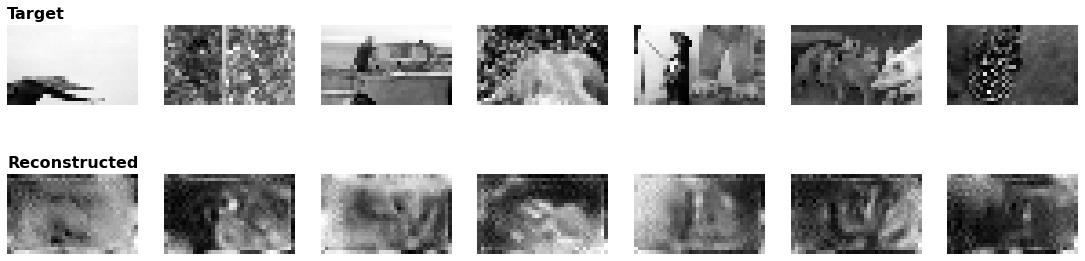

[73/600]
Training progress: [0/373 (0%)]  Loss: 0.016481
Training progress: [100/373 (27%)]  Loss: 0.012058
Training progress: [200/373 (54%)]  Loss: 0.012158
Training progress: [300/373 (80%)]  Loss: 0.017598
train_loss=0.0146


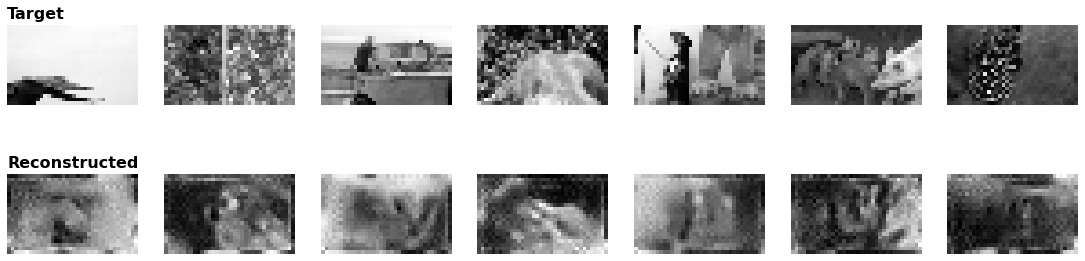

[74/600]
Training progress: [0/373 (0%)]  Loss: 0.016809
Training progress: [100/373 (27%)]  Loss: 0.014466
Training progress: [200/373 (54%)]  Loss: 0.009271
Training progress: [300/373 (80%)]  Loss: 0.014542
train_loss=0.0142


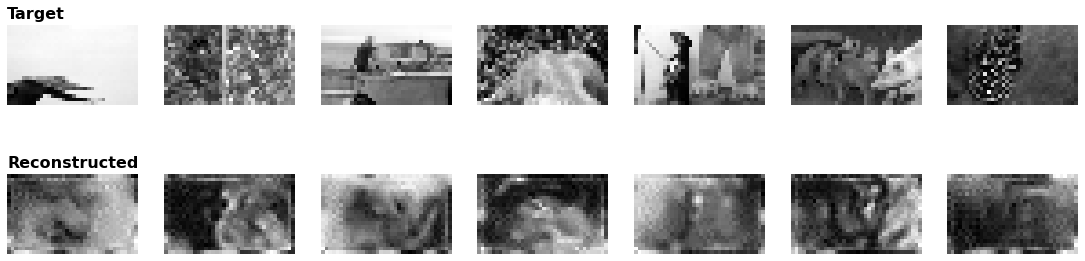

[75/600]
Training progress: [0/373 (0%)]  Loss: 0.013983
Training progress: [100/373 (27%)]  Loss: 0.014962
Training progress: [200/373 (54%)]  Loss: 0.007520
Training progress: [300/373 (80%)]  Loss: 0.011502
train_loss=0.0139


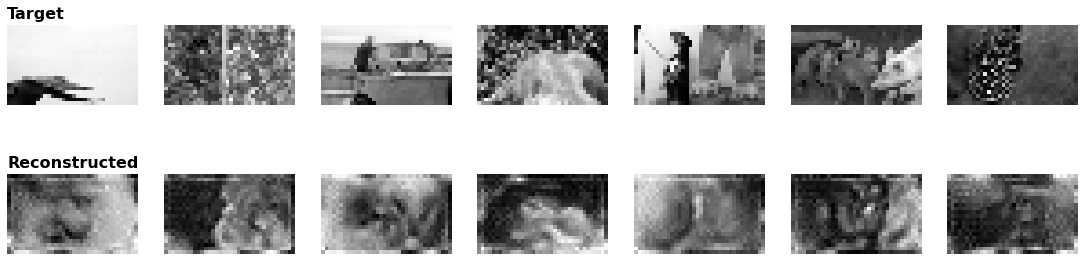

[76/600]
Training progress: [0/373 (0%)]  Loss: 0.008606
Training progress: [100/373 (27%)]  Loss: 0.013040
Training progress: [200/373 (54%)]  Loss: 0.007387
Training progress: [300/373 (80%)]  Loss: 0.013857
train_loss=0.0144


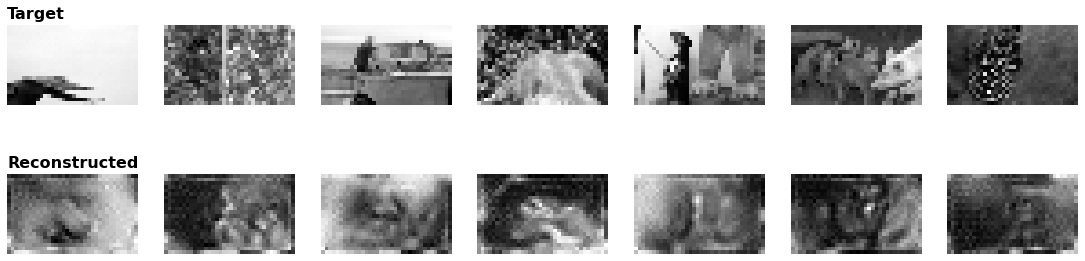

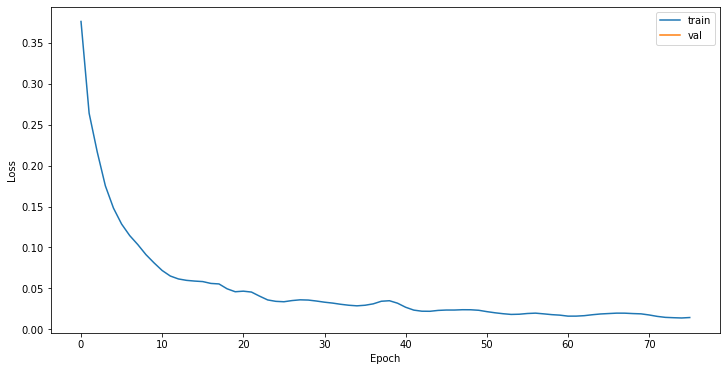

[77/600]
Training progress: [0/373 (0%)]  Loss: 0.008636
Training progress: [100/373 (27%)]  Loss: 0.013602
Training progress: [200/373 (54%)]  Loss: 0.007626
Training progress: [300/373 (80%)]  Loss: 0.026080
train_loss=0.0150


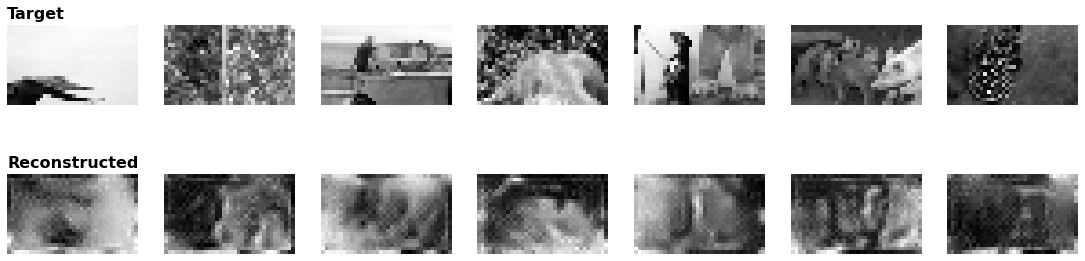

[78/600]
Training progress: [0/373 (0%)]  Loss: 0.009318
Training progress: [100/373 (27%)]  Loss: 0.011235
Training progress: [200/373 (54%)]  Loss: 0.008703
Training progress: [300/373 (80%)]  Loss: 0.024053
train_loss=0.0155


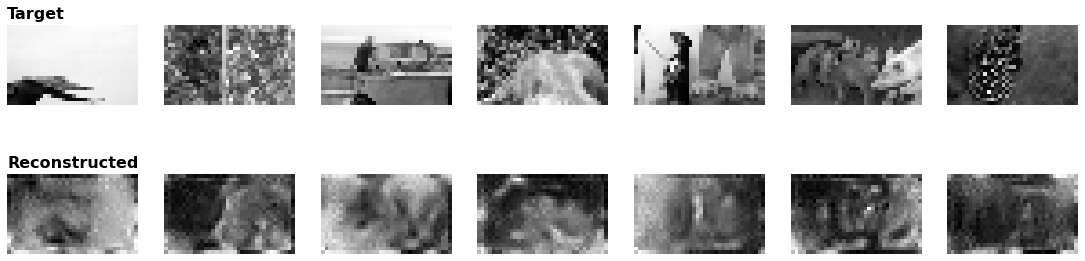

[79/600]
Training progress: [0/373 (0%)]  Loss: 0.012038
Training progress: [100/373 (27%)]  Loss: 0.009235
Training progress: [200/373 (54%)]  Loss: 0.008170
Training progress: [300/373 (80%)]  Loss: 0.013264
train_loss=0.0157


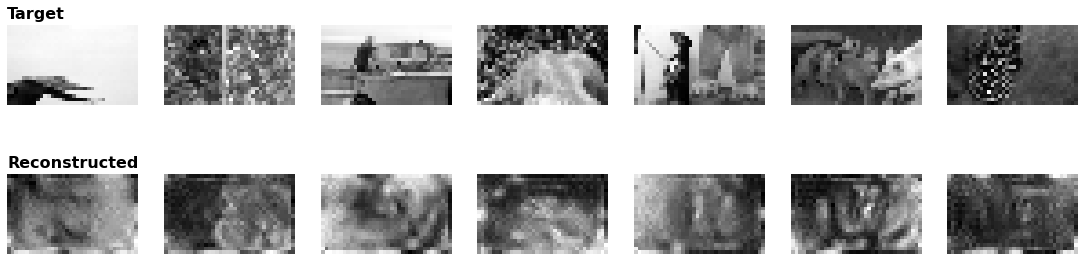

[80/600]
Training progress: [0/373 (0%)]  Loss: 0.022509
Training progress: [100/373 (27%)]  Loss: 0.022908
Training progress: [200/373 (54%)]  Loss: 0.007462
Training progress: [300/373 (80%)]  Loss: 0.023845
train_loss=0.0161


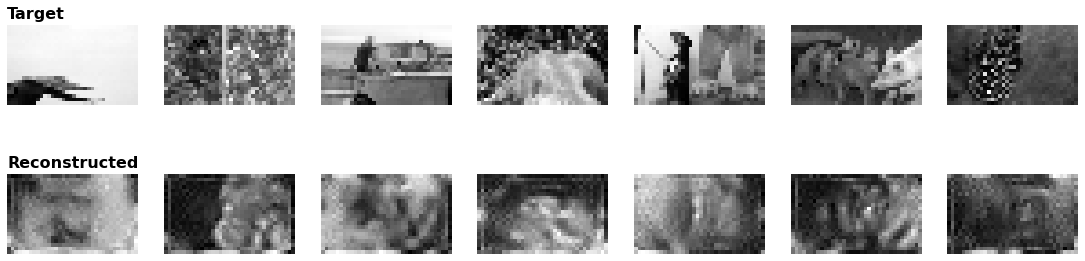

[81/600]
Training progress: [0/373 (0%)]  Loss: 0.033394
Training progress: [100/373 (27%)]  Loss: 0.012520
Training progress: [200/373 (54%)]  Loss: 0.008051
Training progress: [300/373 (80%)]  Loss: 0.023100
train_loss=0.0158


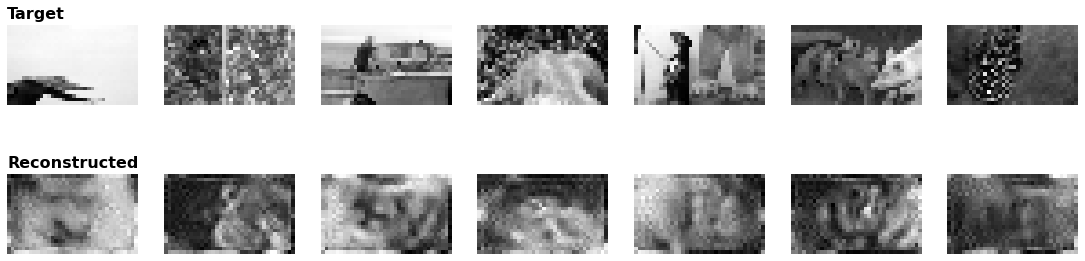

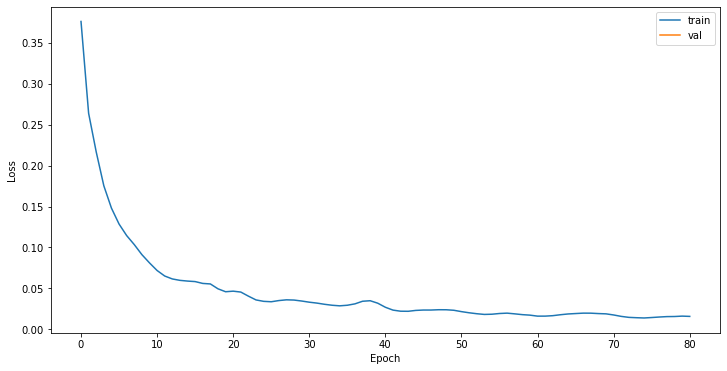

[82/600]
Training progress: [0/373 (0%)]  Loss: 0.016093
Training progress: [100/373 (27%)]  Loss: 0.011263
Training progress: [200/373 (54%)]  Loss: 0.007217
Training progress: [300/373 (80%)]  Loss: 0.010132
train_loss=0.0142


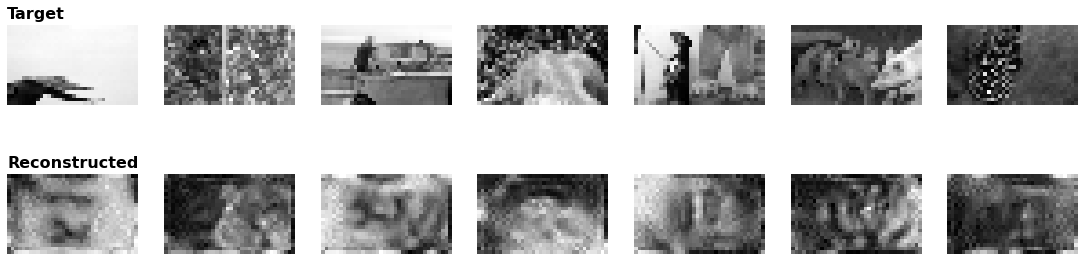

[83/600]
Training progress: [0/373 (0%)]  Loss: 0.014552
Training progress: [100/373 (27%)]  Loss: 0.010431
Training progress: [200/373 (54%)]  Loss: 0.005624
Training progress: [300/373 (80%)]  Loss: 0.009099
train_loss=0.0126


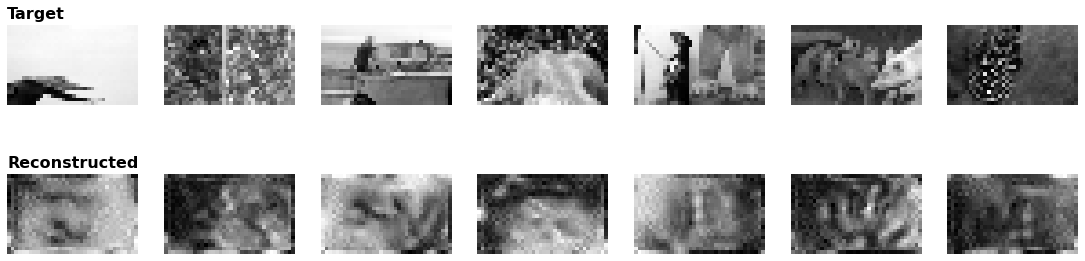

[84/600]
Training progress: [0/373 (0%)]  Loss: 0.010840
Training progress: [100/373 (27%)]  Loss: 0.012765
Training progress: [200/373 (54%)]  Loss: 0.008530
Training progress: [300/373 (80%)]  Loss: 0.009150
train_loss=0.0117


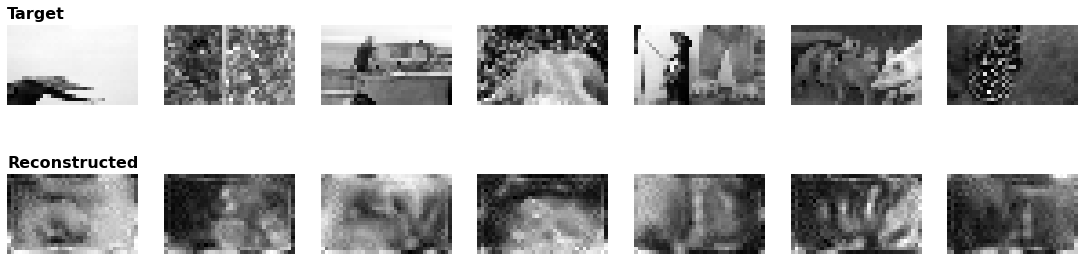

[85/600]
Training progress: [0/373 (0%)]  Loss: 0.012885
Training progress: [100/373 (27%)]  Loss: 0.008768
Training progress: [200/373 (54%)]  Loss: 0.007476
Training progress: [300/373 (80%)]  Loss: 0.009546
train_loss=0.0110


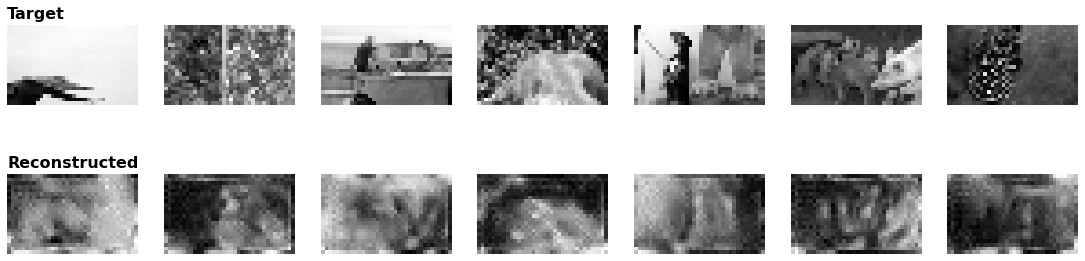

[86/600]
Training progress: [0/373 (0%)]  Loss: 0.012866
Training progress: [100/373 (27%)]  Loss: 0.008713
Training progress: [200/373 (54%)]  Loss: 0.006983
Training progress: [300/373 (80%)]  Loss: 0.008531
train_loss=0.0105


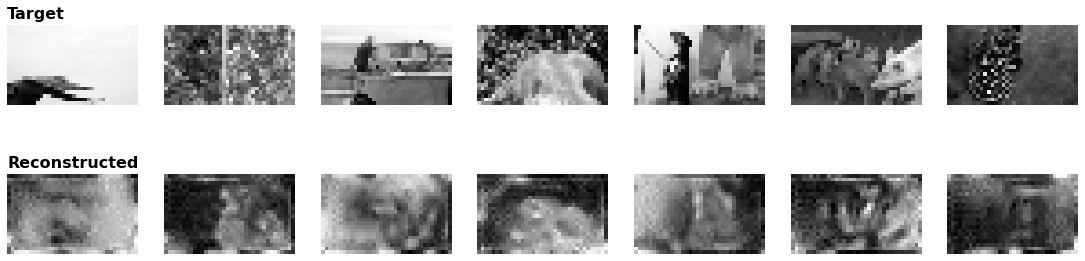

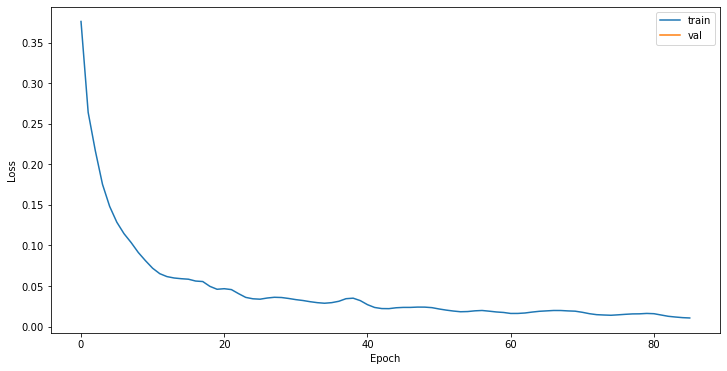

[87/600]
Training progress: [0/373 (0%)]  Loss: 0.009324
Training progress: [100/373 (27%)]  Loss: 0.008005
Training progress: [200/373 (54%)]  Loss: 0.006649
Training progress: [300/373 (80%)]  Loss: 0.009044
train_loss=0.0104


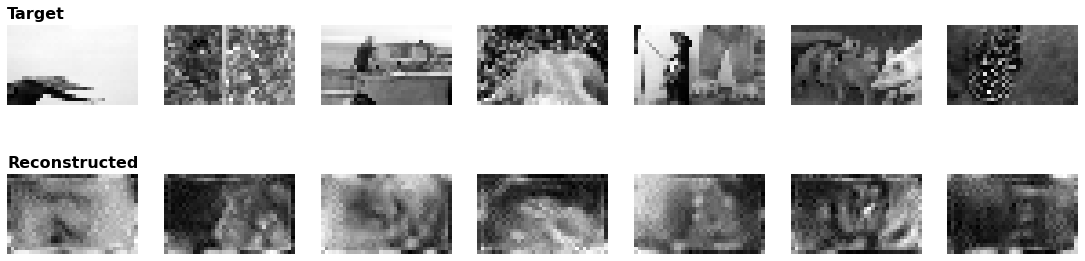

[88/600]
Training progress: [0/373 (0%)]  Loss: 0.008204
Training progress: [100/373 (27%)]  Loss: 0.008652
Training progress: [200/373 (54%)]  Loss: 0.008121
Training progress: [300/373 (80%)]  Loss: 0.008635
train_loss=0.0108


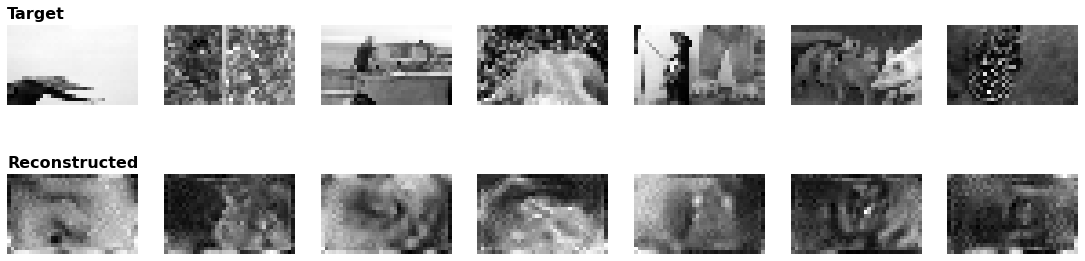

[89/600]
Training progress: [0/373 (0%)]  Loss: 0.008343
Training progress: [100/373 (27%)]  Loss: 0.012118
Training progress: [200/373 (54%)]  Loss: 0.006000
Training progress: [300/373 (80%)]  Loss: 0.008991
train_loss=0.0112


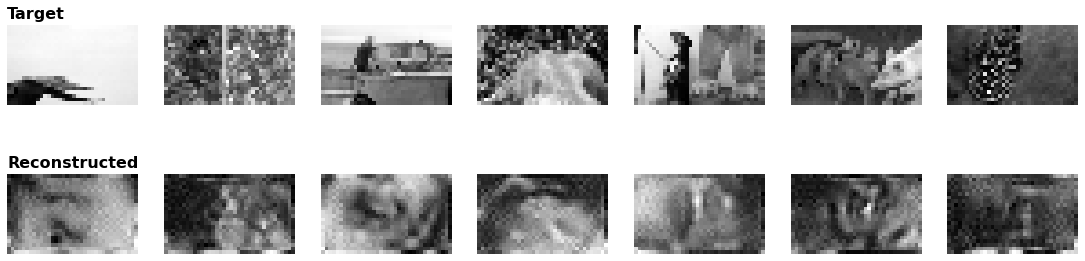

[90/600]
Training progress: [0/373 (0%)]  Loss: 0.012070
Training progress: [100/373 (27%)]  Loss: 0.009380
Training progress: [200/373 (54%)]  Loss: 0.005830
Training progress: [300/373 (80%)]  Loss: 0.008298
train_loss=0.0115


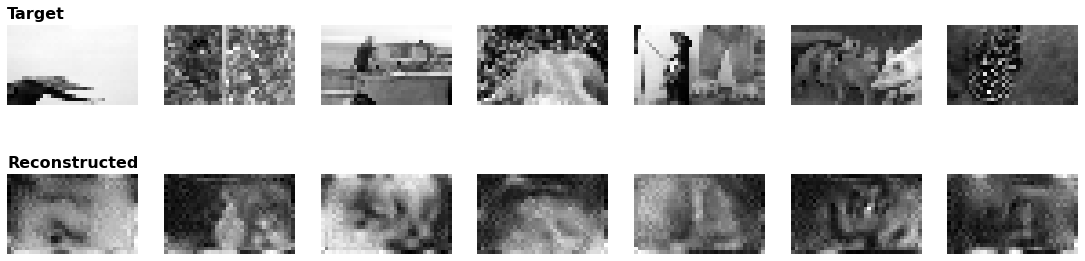

[91/600]
Training progress: [0/373 (0%)]  Loss: 0.016895
Training progress: [100/373 (27%)]  Loss: 0.010471
Training progress: [200/373 (54%)]  Loss: 0.006153
Training progress: [300/373 (80%)]  Loss: 0.010979
train_loss=0.0115


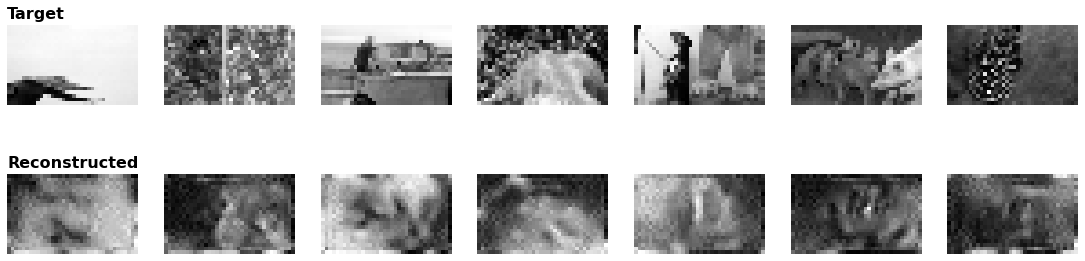

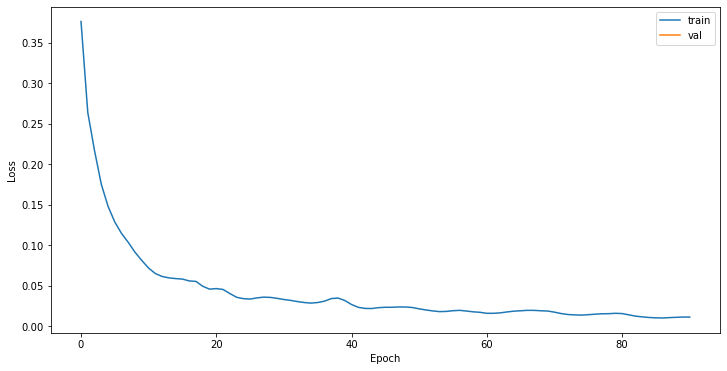

[92/600]
Training progress: [0/373 (0%)]  Loss: 0.008688
Training progress: [100/373 (27%)]  Loss: 0.008960
Training progress: [200/373 (54%)]  Loss: 0.007277
Training progress: [300/373 (80%)]  Loss: 0.017196
train_loss=0.0116


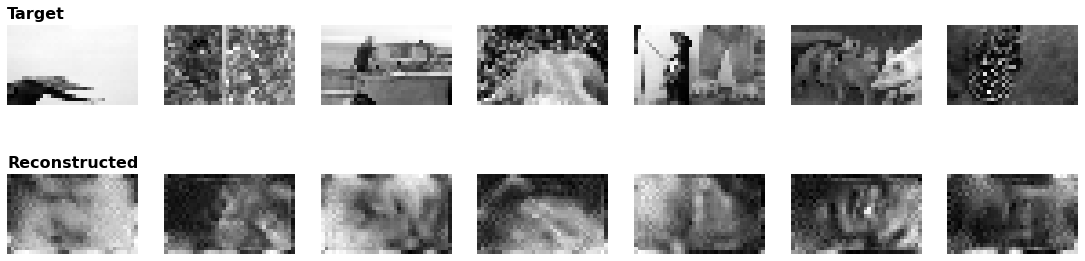

[93/600]
Training progress: [0/373 (0%)]  Loss: 0.006654
Training progress: [100/373 (27%)]  Loss: 0.010700
Training progress: [200/373 (54%)]  Loss: 0.009838
Training progress: [300/373 (80%)]  Loss: 0.010317
train_loss=0.0115


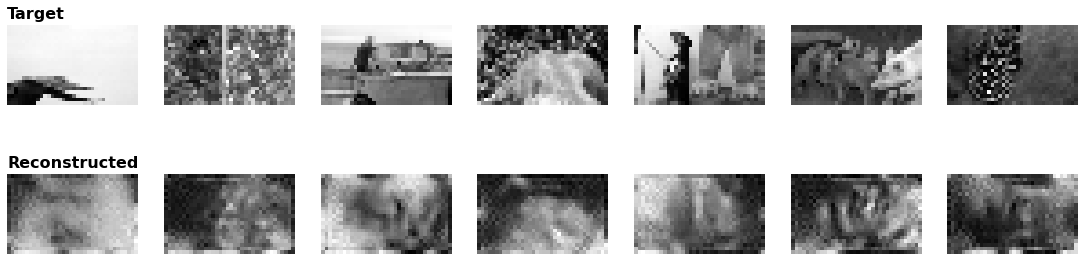

[94/600]
Training progress: [0/373 (0%)]  Loss: 0.006771


KeyboardInterrupt: 

In [16]:
### train
s, e = len(history["train_loss"]), config["decoder"]["n_epochs"]
for epoch in range(s, e):
    print(f"[{epoch + 1}/{e}]")

    ### train and val
    dls, neuron_coords = get_all_data(config=config)
    train_dataloader, val_dataloader = dls["mouse_v1"]["train"], dls["mouse_v1"]["val"]
    train_loss = train(
        model=decoder,
        dataloader=train_dataloader,
    )
    # val_losses = val(
    #     model=decoder,
    #     dataloader=val_dataloader,
    #     loss_fn=loss_fn_val,
    #     config=config,
    # )

    ### save best model
    # if val_losses["total"] < best["val_loss"]:
    #     best["val_loss"] = val_losses["total"]
    #     best["epoch"] = epoch
    #     best["model"] = deepcopy(decoder.state_dict())

    ### log
    history["train_loss"].append(train_loss)
    # history["val_loss"].append(val_losses["total"])
    # if config["wandb"]: wdb_run.log({"train_loss": train_loss, "val_loss": val_losses["total"]}, commit=False)
    # print(f"{train_loss=:.4f}, {val_losses['total']=:.4f}", end="")
    print(f"{train_loss=:.4f}", end="")
    # for data_key, loss in val_losses.items():
    #     if data_key != "total":
    #         print(f", {data_key}: {loss:.4f}", end="")
    print("")

    ### plot reconstructions
    stim_pred = decoder(
        resp[:8].to(config["device"]),
        train=False,
        data_key=sample_data_key,
        neuron_coords=neuron_coords[sample_data_key],
        pupil_center=pupil_center[:8].to(config["device"]),
    )[0].detach()
    fig = plot_comparison(target=crop(stim[:8], config["crop_win"]).cpu(), pred=crop(stim_pred[:8], config["crop_win"]).cpu(), save_to=make_sample_path(epoch, ""))
    if config["wandb"]: wdb_run.log({"val_stim_reconstruction": fig})

    ### plot losses
    if epoch % 5 == 0 and epoch > 0:
        plot_losses(history=history, epoch=epoch, save_to=os.path.join(config["dir"], f"losses_{epoch}.png") if config["decoder"]["save_run"] else None)

    ### save ckpt
    if epoch % 5 == 0 and epoch > 0:
        ### ckpt
        if config["decoder"]["save_run"]:
            torch.save({
                "decoder": decoder.state_dict(),
                "history": history,
                "config": config,
                "best": best,
            }, os.path.join(config["dir"], "ckpt", f"decoder_{epoch}.pt"), pickle_module=dill)

In [28]:
decoder.n_steps = 150

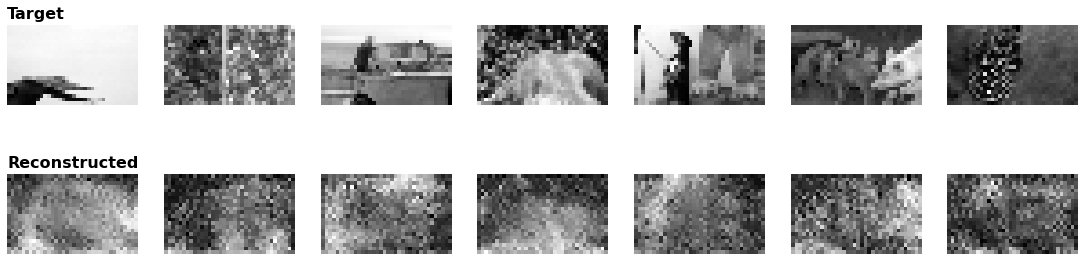

In [29]:
stim_pred_best, resp_pred_best, reconstruction_history = decoder(
    resp.to(config["device"]),
    train=False,
    data_key=sample_data_key,
    neuron_coords=neuron_coords[sample_data_key],
    pupil_center=pupil_center.to(config["device"]),
)
stim_pred_best = stim_pred_best.detach().cpu()
fig = plot_comparison(
    target=crop(stim[:8], config["crop_win"]).cpu(),
    pred=crop(stim_pred_best[:8], config["crop_win"]).cpu(),
    save_to=os.path.join(config["dir"], "stim_comparison_best.png") if config["decoder"]["save_run"] else None,
)

In [17]:
### final evaluation + logging + saving
print(f"Best val loss: {best['val_loss']:.4f} at epoch {best['epoch']}")

### save final ckpt
if config["decoder"]["save_run"]:
    torch.save({
        "decoder": decoder.state_dict(),
        "history": history,
        "config": config,
        "best": best,
    }, os.path.join(config["dir"], f"decoder.pt"), pickle_module=dill)

### eval on test set w/ current params
print("Evaluating on test set with current model...")
dls, neuron_coords = get_all_data(config=config)
test_loss_curr = val(
    model=decoder,
    dataloader=dls["mouse_v1"]["test"],
    loss_fn=loss_fn_val,
    config=config,
)
print(f"  Test loss (current model): {test_loss_curr['total']:.4f}")

### load best model
decoder.load_state_dict(best["model"])

### eval on test set w/ best params
print("Evaluating on test set with best model...")
dls, neuron_coords = get_all_data(config=config)
test_loss_final = val(
    model=decoder,
    dataloader=dls["mouse_v1"]["test"],
    loss_fn=loss_fn_val,
    config=config,
)
print(f"  Test loss (best model): {test_loss_final['total']:.4f}")

### plot reconstructions of the final model
stim_pred_best, resp_pred_best, reconstruction_history = decoder(
    resp.to(config["device"]),
    train=False,
    data_key=sample_data_key,
    neuron_coords=neuron_coords[sample_data_key],
    pupil_center=pupil_center.to(config["device"]),
)
stim_pred_best = stim_pred_best.detach().cpu()
fig = plot_comparison(
    target=crop(stim[:8], config["crop_win"]).cpu(),
    pred=crop(stim_pred_best[:8], config["crop_win"]).cpu(),
    save_to=os.path.join(config["dir"], "stim_comparison_best.png") if config["decoder"]["save_run"] else None,
)

### log
if config["wandb"]:
    wandb.run.summary["best_val_loss"] = best["val_loss"]
    wandb.run.summary["best_epoch"] = best["epoch"]
    wandb.run.summary["curr_test_loss"] = test_loss_curr["total"]
    wandb.run.summary["final_test_loss"] = test_loss_final["total"]
    wandb.run.summary["best_reconstruction"] = fig

### save/delete wandb run
if config["wandb"]:
    if input("Delete run with 'd', save with anything else: ") == "d":
        print("Deleting wandb run...")
        api = wandb.Api()
        run = api.run(f"johnny1188/{config['wandb']['project']}/{wdb_run.id}")
        run.delete()
    else:
        wdb_run.finish()

### plot losses
plot_losses(
    history=history,
    save_to=None if not config["decoder"]["save_run"] else os.path.join(config["dir"], f"losses.png"),
)

Best val loss: inf at epoch 0
Evaluating on test set with current model...
  Test loss (current model): 1.3264


TypeError: Expected state_dict to be dict-like, got <class 'NoneType'>.

In [ ]:
### show training reconstructions
datapoint_training = next(iter(dls["mouse_v1"]["train"].dataloaders[0]))
stim_training, resp_training, pupil_center_training = datapoint_training.images, datapoint_training.responses, datapoint_training.pupil_center
stim_training_pred_best = decoder(
    resp_training.to(config["device"]),
    train=False,
    data_key=sample_data_key,
    neuron_coords=neuron_coords[sample_data_key],
    pupil_center=pupil_center_training.to(config["device"]),
)[0].detach().cpu()
plot_comparison(
    target=crop(stim_training[:8], config["crop_win"]).cpu(),
    pred=crop(stim_training_pred_best[:8], config["crop_win"]).cpu(),
    save_to=os.path.join(config["dir"], "training_stim_comparison_best.png") if config["decoder"]["save_run"] else None,
)